In [77]:
from default import *

PORT = 5002
%cd -q {PROJECT_HOME}

In [2]:
import os
from copy import deepcopy

figure_dir = os.getcwd() + '/022025_experiment/figures'

import numpy as np
import torch
import mlflow
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from models.architecture import MLP
from models.processing import StandardScaler
from torch import nn

import pandas as pd

import torch.nn.functional as F

from mlflow.pytorch import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

from losses import StiffnessToLoadLoss

import ast

import torchmetrics.functional.regression as R
from dataset import FixedPrattTrussDatasetSingleTarget

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from tools.mlflow import BasicDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [3]:
# Load the datasets
_validation_ds = FixedPrattTrussDatasetSingleTarget("data/dataset/pratt_truss_bridge/single_ea/validation_8192.hdf5")

# MSE Only

In [4]:
def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, _, _ = batch
    input, target = input.to(device), target.to(device)

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    optimizer.zero_grad()
    loss = criterion(z_target_pred, z_target)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        loss = criterion(z_target_pred, z_target)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch + 1)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch + 1)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch + 1, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': criterion.__name__,
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

In [5]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

### Model capacity

In [6]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 1,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/07 21:22:58 INFO mlflow.tracking.fluent: Experiment with name 'model_capacity' does not exist. Creating a new experiment.


🏃 View run persistent-grouse-65 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/06ac4c96cd324e30bc382e6d7a9158f2
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run calm-cat-874 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/5096e4b2d20841748c4c4bde28b12461
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run enthused-frog-985 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/3a351f4be5084ec88590cc042a2ec328
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run defiant-shad-43 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/747e5635df7a4b4aa5426a8067e3b56d
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run capricious-hen-184 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/d57cef19a8554b42bd0e08db831f815f
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/5630959

In [7]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

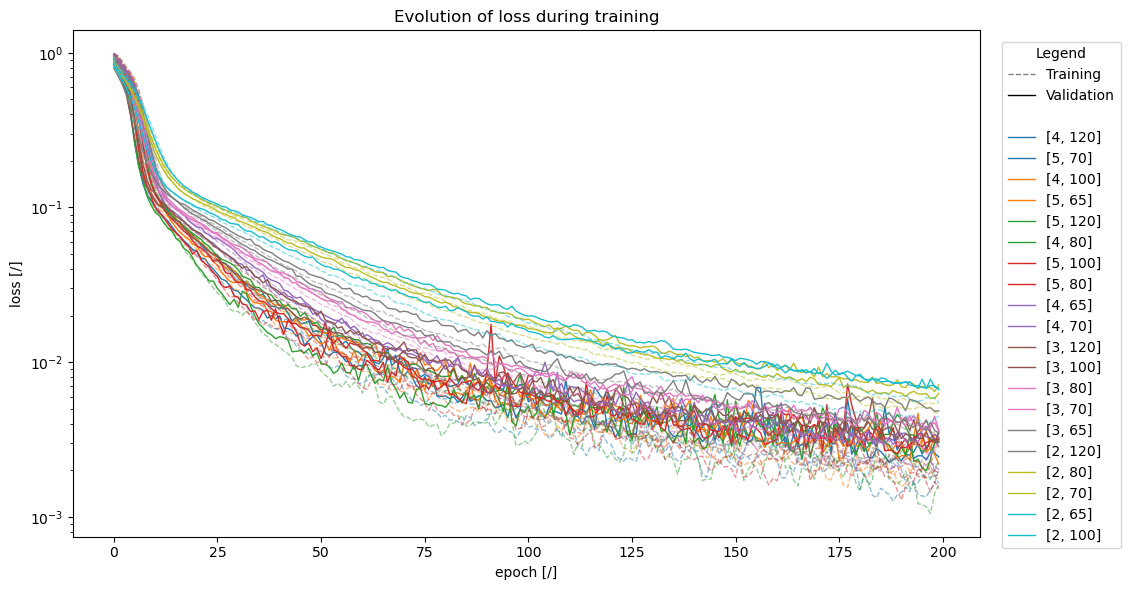

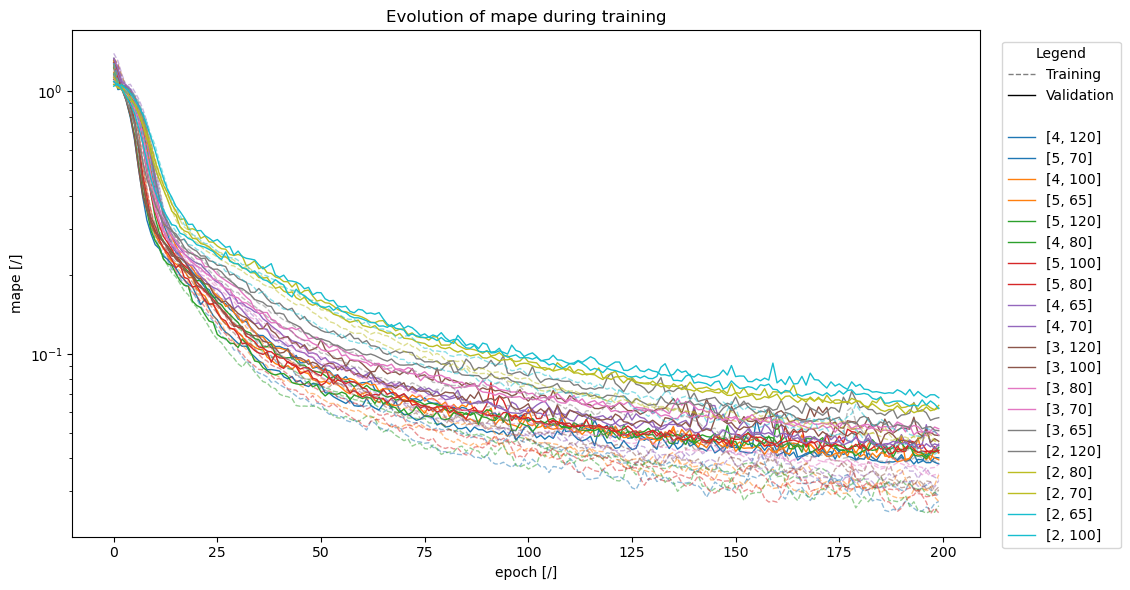

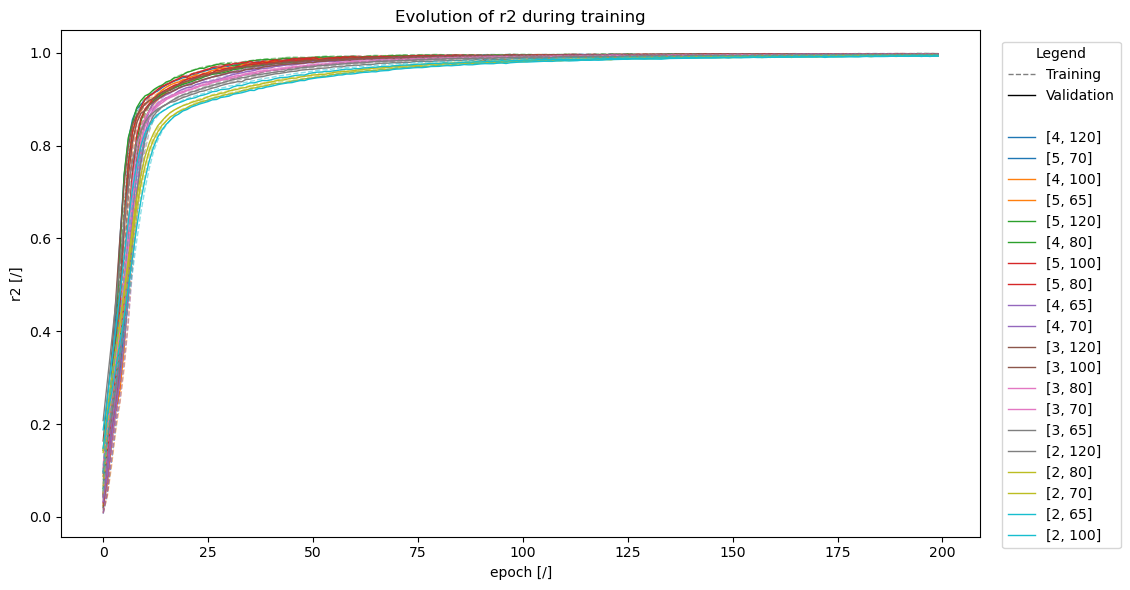

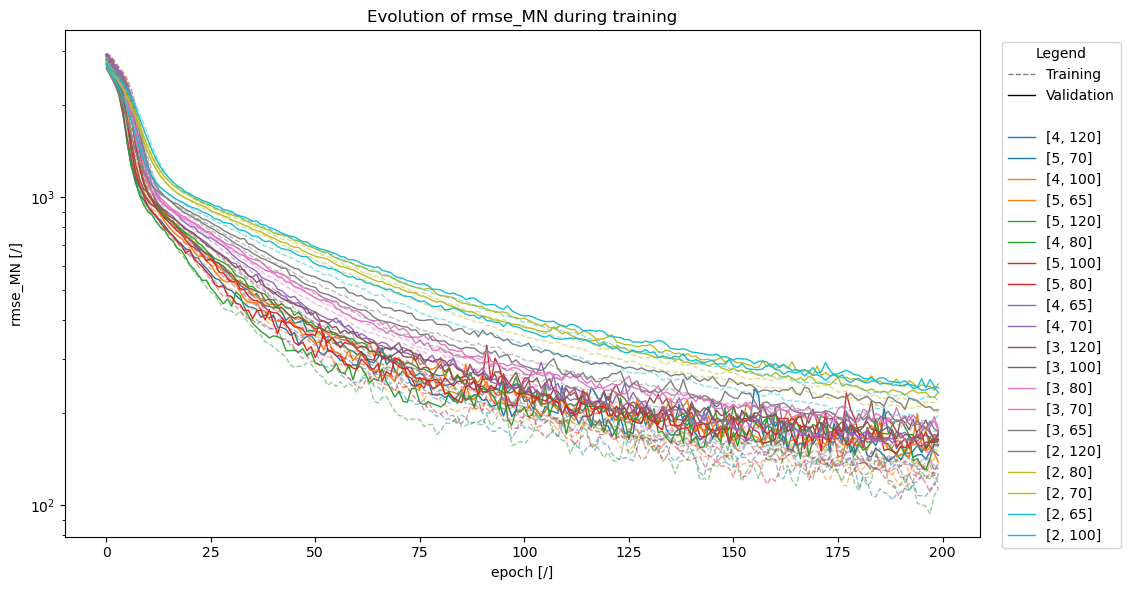

In [8]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [6]:
best_hidden_dims = [65 for _ in range(5)]

### Activation function

In [10]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/07 22:02:45 INFO mlflow.tracking.fluent: Experiment with name 'activation_function' does not exist. Creating a new experiment.


🏃 View run glamorous-crane-142 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/a9282e8a8822408bbcb9603bbbfdb7da
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run casual-stoat-713 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/5a8e341540e84f45ab53cb21648bad67
🏃 View run resilient-wolf-932 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/78ac78044f4446bd8eb6509b47bf8862
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run blushing-dove-732 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/d74282a4553a480cb159db038c4cf423
🏃 View run unequaled-mule-910 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/65687d77998b4765a376fb3b43efd49d
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/9

In [11]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

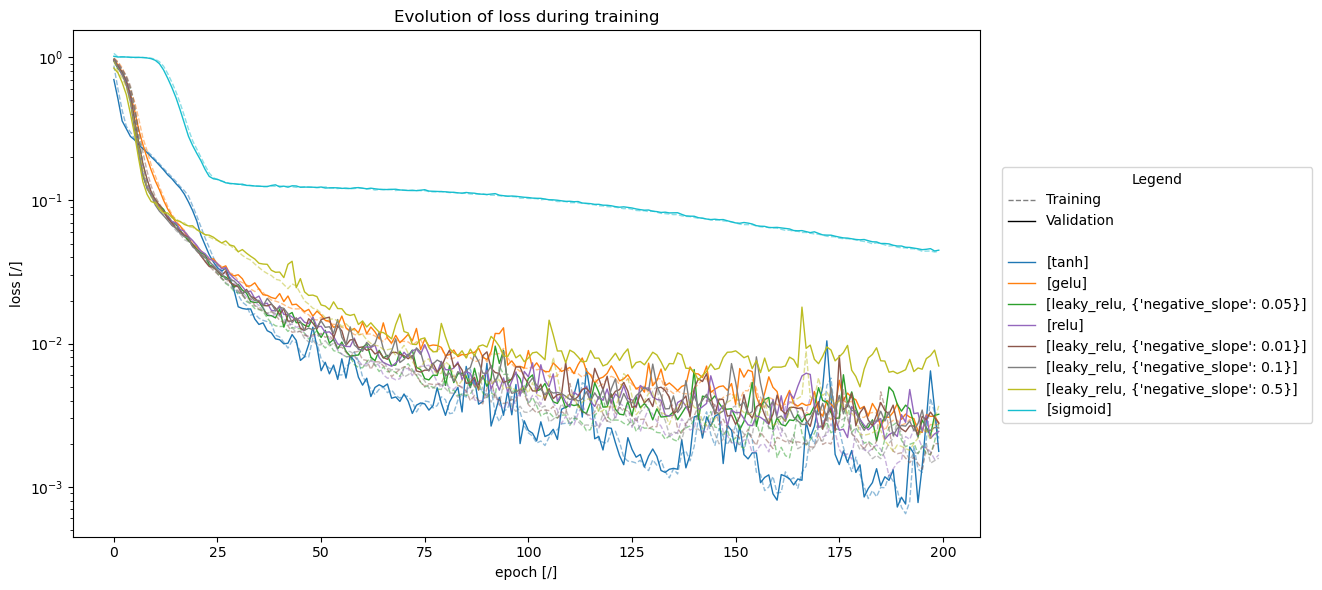

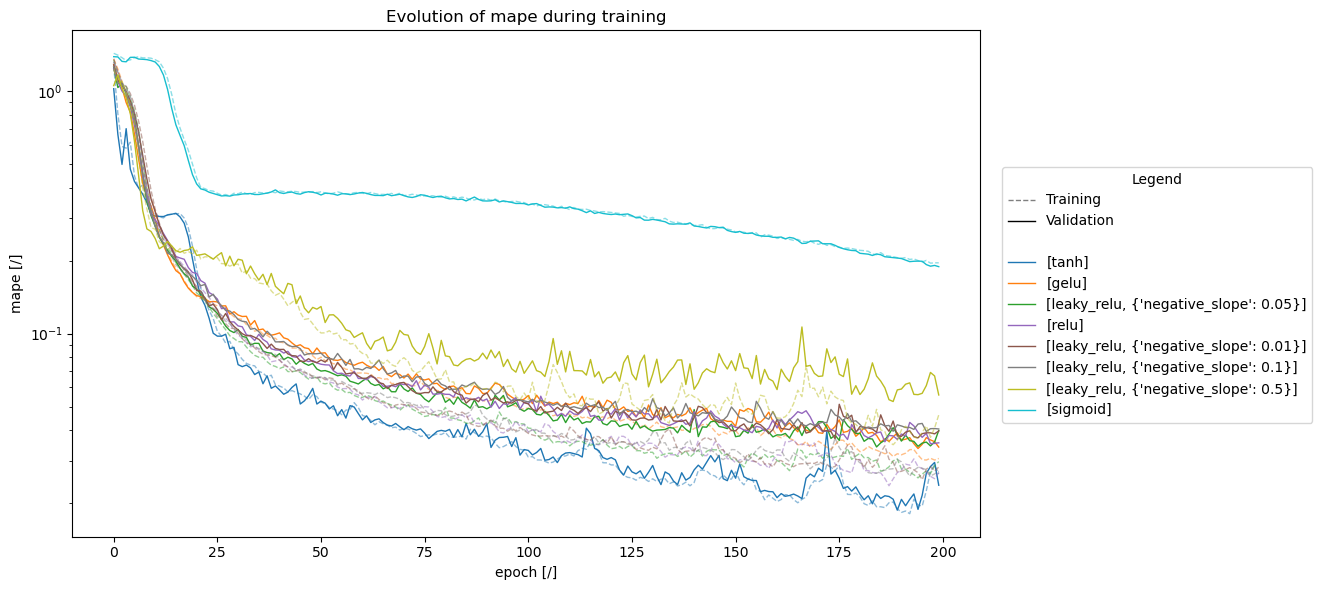

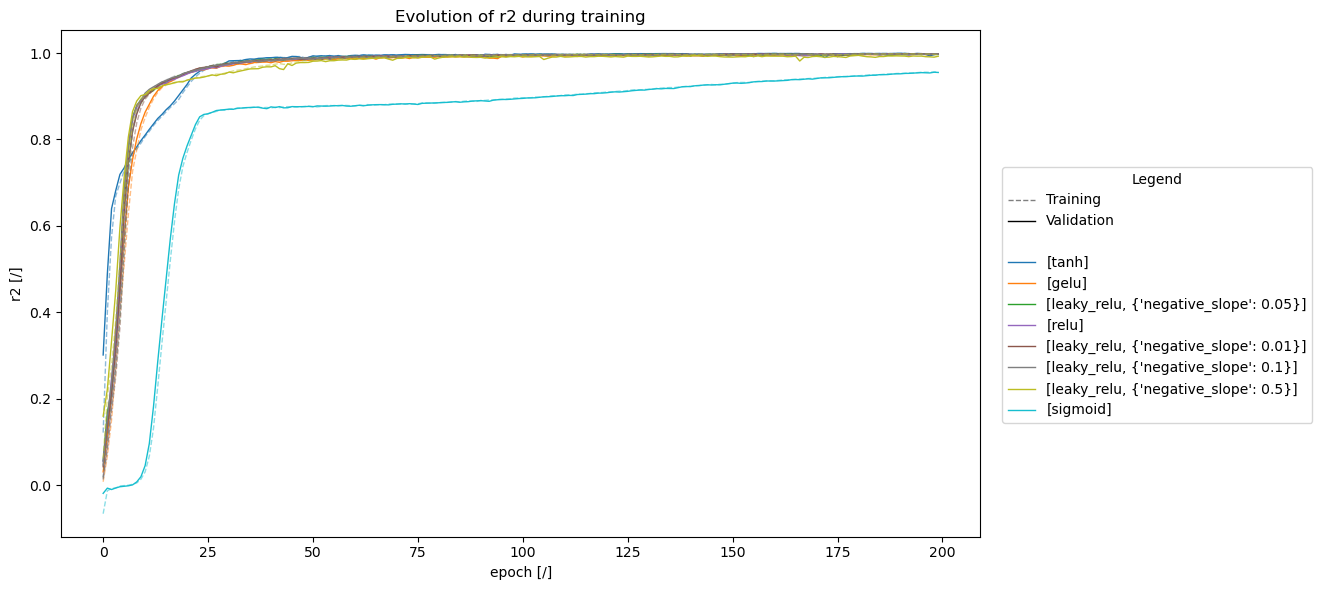

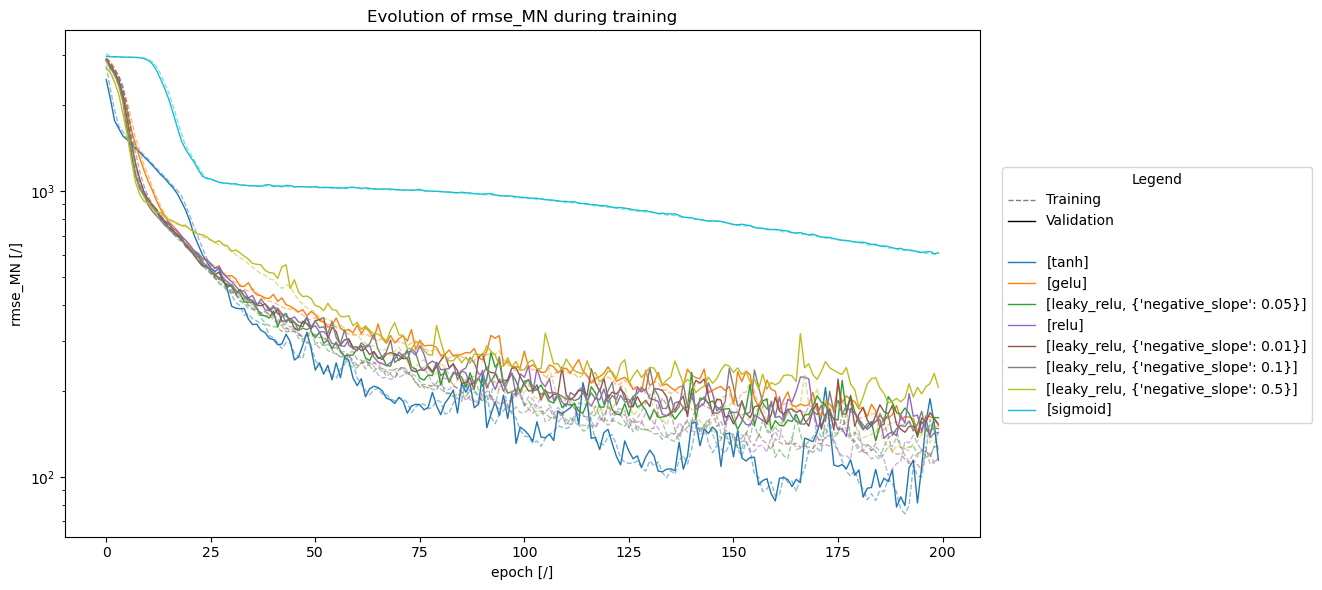

In [12]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [7]:
best_activation = 'tanh'
best_activation_params = None

### Learning rate

In [14]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
lr_values = sorted(np.hstack([f * np.logspace(-4, -3, 2) for f in [1, 2.5, 5, 7.5]]))

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in lr_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': 'mse'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

2025/05/07 22:42:15 INFO mlflow.tracking.fluent: Experiment with name 'learning_rate' does not exist. Creating a new experiment.


🏃 View run crawling-bee-451 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/9abf4528a8884e2087ff590c07966ea7
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run aged-newt-773 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/a9796271f29d46999a8172db0813ad44
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run tasteful-dog-812 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/fd38c80c9eb04a85b114e4323bfe36f5
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run capable-yak-705 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/ab85718ce0754307a9cb2b7160d140e9
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run awesome-crow-88 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/34fa85e26d8748d28d09c8b9dbb241d5
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/59259549047853

In [90]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

AttributeError: 'NoneType' object has no attribute 'experiment_id'

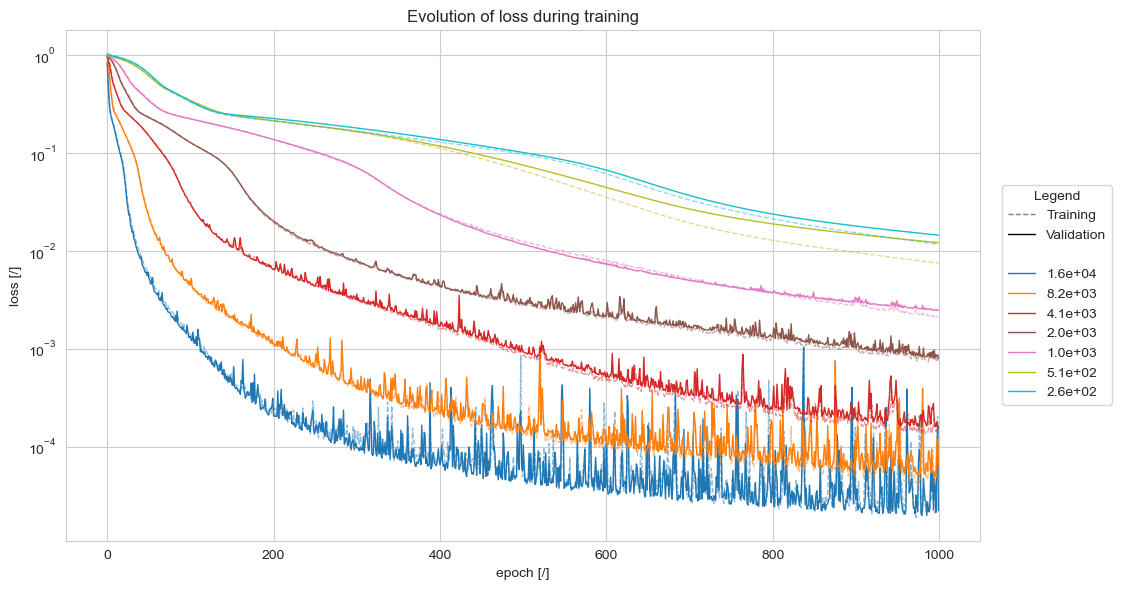

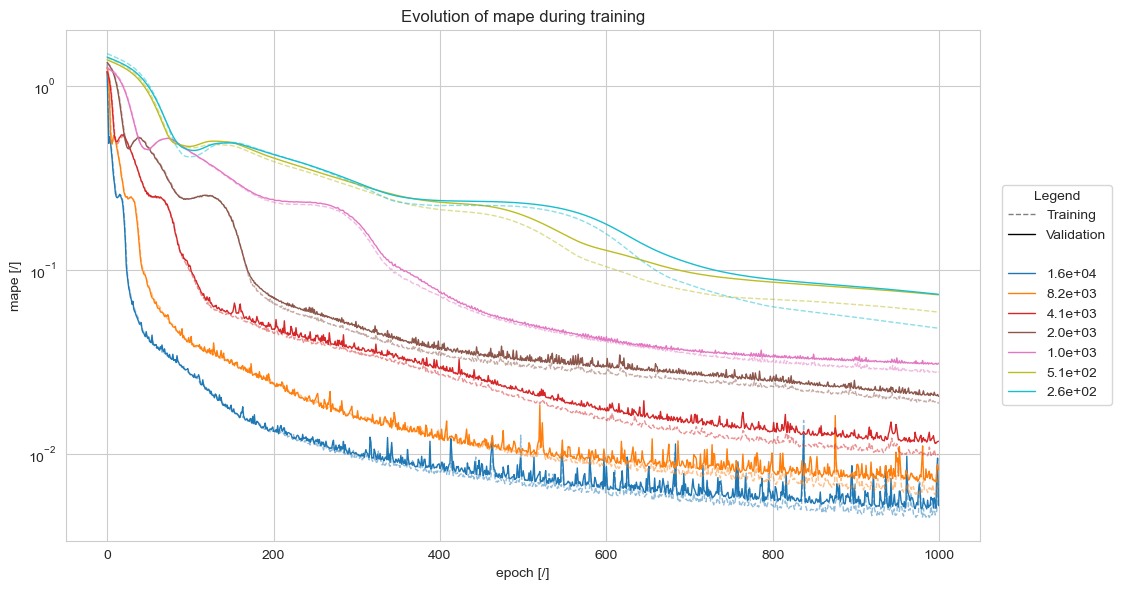

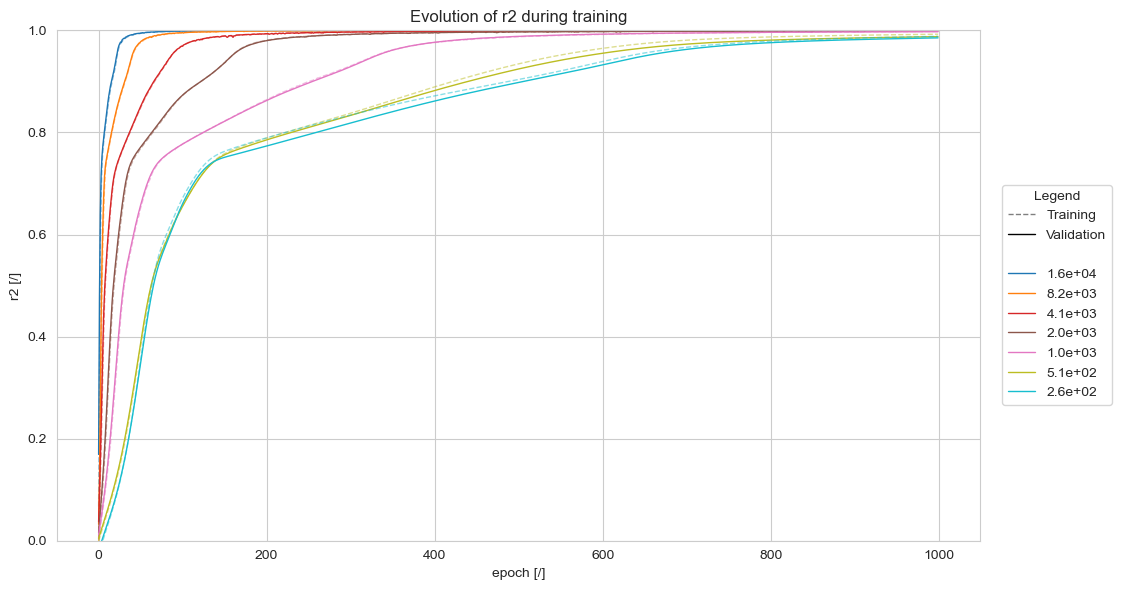

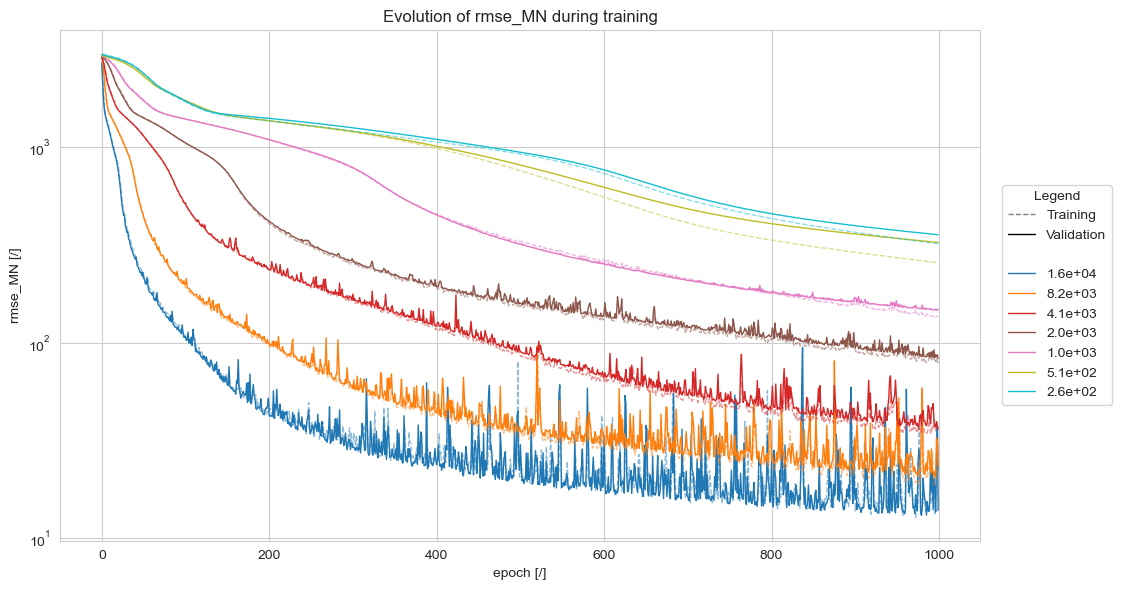

In [91]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [75]:
best_lr = 1e-4

### Training

In [78]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDatasetSingleTarget(dataset_path)
        validation_dataset = _validation_ds
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 1,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, nn.MSELoss,
                                 -1, log_step, {'loss': 'mse', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run bemused-ray-571 at: http://127.0.0.1:5002/#/experiments/127456463834714701/runs/0858eccea1e74588b4eb15c417bf33ae
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/127456463834714701
🏃 View run debonair-ape-671 at: http://127.0.0.1:5002/#/experiments/127456463834714701/runs/c3980735d59f465f83abea5cae2b8fcc
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/127456463834714701
🏃 View run carefree-ape-742 at: http://127.0.0.1:5002/#/experiments/127456463834714701/runs/e7d4db9aeb1e466c8cb93353e5a91c3f
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/127456463834714701
🏃 View run sneaky-shad-657 at: http://127.0.0.1:5002/#/experiments/127456463834714701/runs/ccbd7c1059c2440d87d9e2fbfa7cf7b4
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/127456463834714701
🏃 View run languid-kite-572 at: http://127.0.0.1:5002/#/experiments/127456463834714701/runs/840356b4e207487db1ad596cf364d5cb
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/12745646383

In [82]:
runs_df

run_id       experiment_id    status  \
0   cec6dfac44604295ae8fbff150ee3f15  127456463834714701  FINISHED   
1   9c81e0418c1c4aa6930d93e9e2bdd1cd  127456463834714701  FINISHED   
2   ce1333832fdd4ea0a9e7599db4a7b759  127456463834714701  FINISHED   
3   3560694e33df4535a55336f87a355ad8  127456463834714701  FINISHED   
4   840356b4e207487db1ad596cf364d5cb  127456463834714701  FINISHED   
5   ccbd7c1059c2440d87d9e2fbfa7cf7b4  127456463834714701  FINISHED   
6   e7d4db9aeb1e466c8cb93353e5a91c3f  127456463834714701  FINISHED   
7   c3980735d59f465f83abea5cae2b8fcc  127456463834714701  FINISHED   
8   0858eccea1e74588b4eb15c417bf33ae  127456463834714701  FINISHED   
9   11efbf3e7f6142b7ab8981915eeaa4b8  127456463834714701  FINISHED   
10  3ad6a3b1f76c49ea9e4afbb02f7941ac  127456463834714701  FINISHED   
11  afc26b534a4f41b0b0e4363ebf0d8fc4  127456463834714701  FINISHED   
12  c4a630374f4a43e9bc27fa8acf7849d7  127456463834714701  FINISHED   
13  80a816b8ef5f4f1e8d3997c12e3d1512  127456463834714701  FINISHED   
14  68f957af755f4a8282670b6767d85344  127456463834714701  FINISHED   
15  d3d199b3f94a48c2a49c147fb9836767  127456463834714701  FINISHED   

                                         artifact_uri  \
0   mlflow-artifacts:/127456463834714701/cec6dfac4...   
1   mlflow-artifacts:/127456463834714701/9c81e0418...   
2   mlflow-artifacts:/127456463834714701/ce1333832...   
3   mlflow-artifacts:/127456463834714701/3560694e3...   
4   mlflow-artifacts:/127456463834714701/840356b4e...   
5   mlflow-artifacts:/127456463834714701/ccbd7c105...   
6   mlflow-artifacts:/127456463834714701/e7d4db9ae...   
7   mlflow-artifacts:/127456463834714701/c3980735d...   
8   mlflow-artifacts:/127456463834714701/0858eccea...   
9   mlflow-artifacts:/127456463834714701/11efbf3e7...   
10  mlflow-artifacts:/127456463834714701/3ad6a3b1f...   
11  mlflow-artifacts:/127456463834714701/afc26b534...   
12  mlflow-artifacts:/127456463834714701/c4a630374...   
13  mlflow-artifacts:/127456463834714701/80a816b8e...   
14  mlflow-artifacts:/127456463834714701/68f957af7...   
15  mlflow-artifacts:/127456463834714701/d3d199b3f...   

                         start_time                         end_time  \
0  2025-05-09 15:29:57.312000+00:00 2025-05-09 15:54:10.580000+00:00   
1  2025-05-09 15:29:45.171000+00:00 2025-05-09 15:48:16.119000+00:00   
2  2025-05-09 15:21:23.493000+00:00 2025-05-09 15:53:30.516000+00:00   
3  2025-05-09 15:21:22.423000+00:00 2025-05-09 15:46:23.782000+00:00   
4  2025-05-09 15:18:52.049000+00:00 2025-05-09 15:38:44.108000+00:00   
5  2025-05-09 15:18:51.666000+00:00 2025-05-09 15:34:37.199000+00:00   
6  2025-05-09 15:18:51.517000+00:00 2025-05-09 15:31:56.769000+00:00   
7  2025-05-09 15:18:51.338000+00:00 2025-05-09 15:29:57.251000+00:00   
8  2025-05-09 15:18:51.311000+00:00 2025-05-09 15:29:45.108000+00:00   
9  2025-05-09 13:02:59.069000+00:00 2025-05-09 13:17:41.589000+00:00   
10 2025-05-09 13:02:48.046000+00:00 2025-05-09 13:14:23.747000+00:00   
11 2025-05-09 12:54:51.429000+00:00 2025-05-09 13:09:05.147000+00:00   
12 2025-05-09 12:54:51.230000+00:00 2025-05-09 13:06:22.539000+00:00   
13 2025-05-09 12:54:51.112000+00:00 2025-05-09 13:04:25.791000+00:00   
14 2025-05-09 12:54:51.060000+00:00 2025-05-09 13:02:48.001000+00:00   
15 2025-05-09 12:54:51.058000+00:00 2025-05-09 13:02:59.011000+00:00   

    metrics.train_loss  metrics.train_rmse_MN  metrics.val_mape  \
0             0.000064              21.669632          0.005271   
1             0.000103              28.662464          0.008275   
2             0.000083              26.298023          0.005813   
3             0.000249              40.963928          0.008247   
4             0.000147              35.687527          0.011796   
5             0.000711              78.269859          0.020659   
6             0.002111             135.725967          0.031279   
7             0.007448             256.085022          0.073459   
8             0.011609             320.36

In [83]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.learning_rate'] == '1.0e-04') &
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

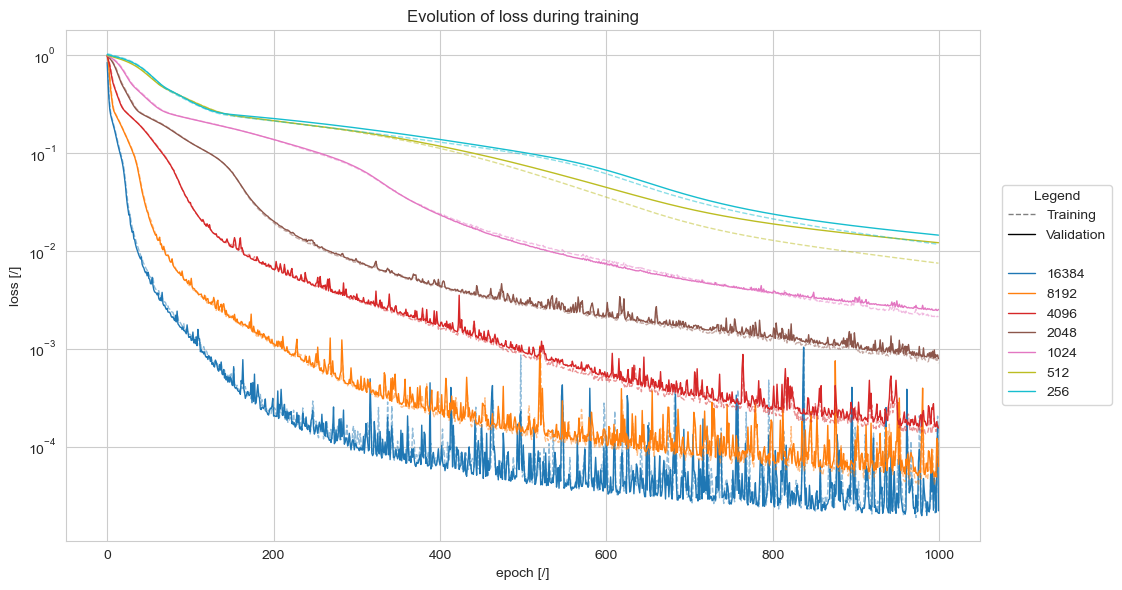

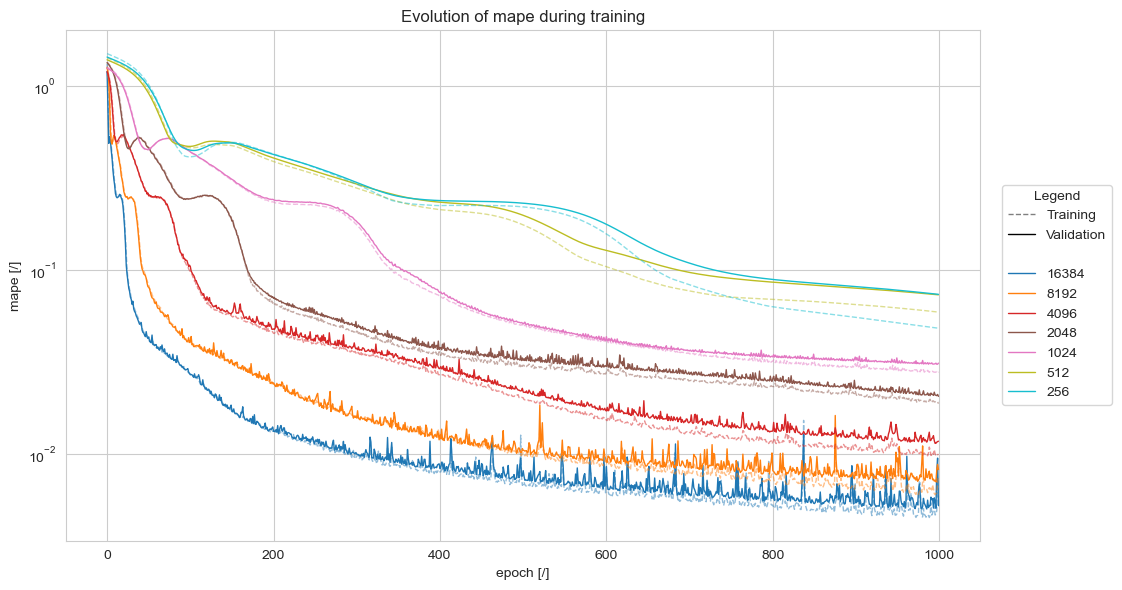

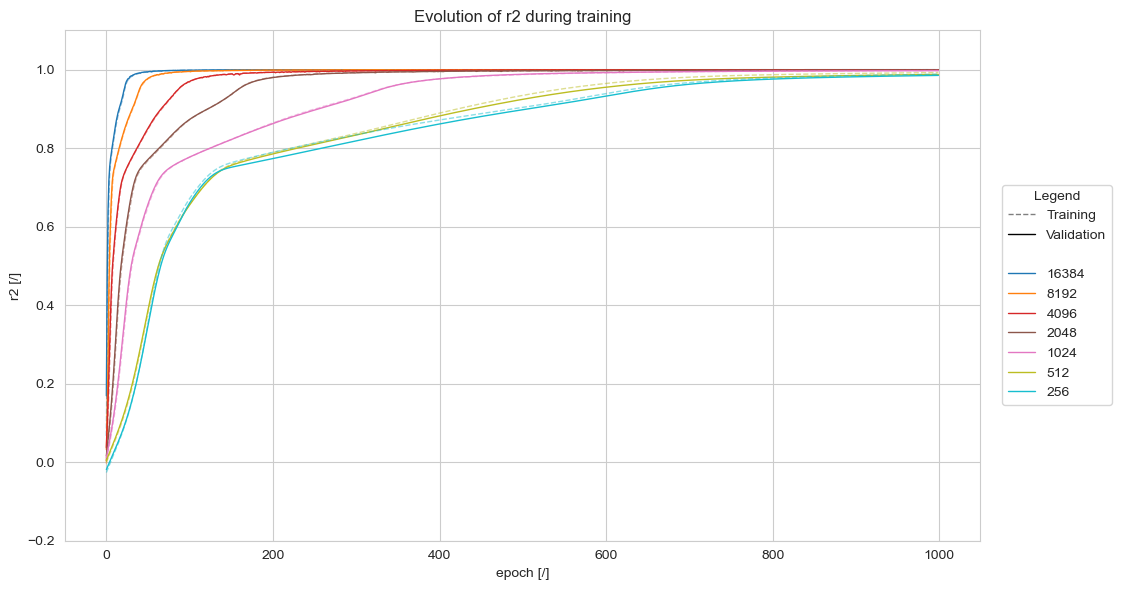

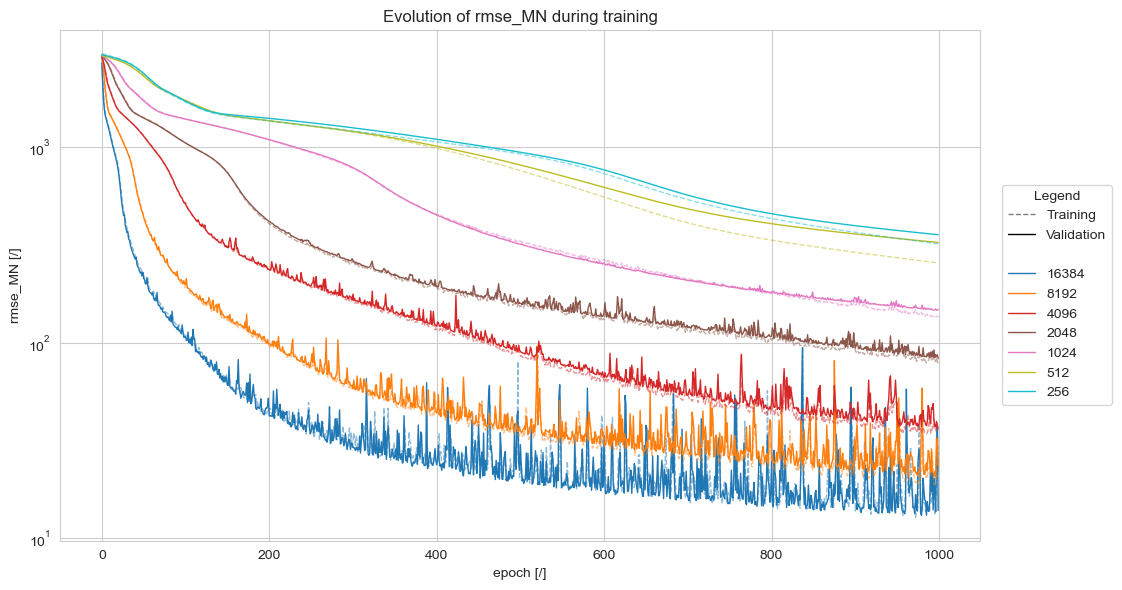

In [85]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [21]:
%%capture
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

results = []

for f in np.linspace(0, .1, 6):
    validation_ds = FixedPrattTrussDatasetSingleTarget(
        "data/dataset/pratt_truss_bridge/member_ea/validation_8192.hdf5",
        f_noise_length=None,
        f_noise_loads=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_strain=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_displacement=lambda size: np.random.normal(1, f / 4, size=size),
    )

    dl = DataLoader(validation_ds, batch_size=8192)

    for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
        artifact_uri = runs_df.iloc[i]['artifact_uri']
        size = runs_df.iloc[i]['params.train_size']

        uri = f"{artifact_uri}/input_scaler/"
        input_scaler = load_model(uri)

        uri = f"{artifact_uri}/target_scaler/"
        target_scaler = load_model(uri)

        uri = f"{artifact_uri}/mape_model/"
        model = load_model(uri)

        for batch in dl:
            metrics = validation(model, batch, input_scaler, target_scaler, F.mse_loss)
        results.append((size, f, metrics))

In [22]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("noise_sensitivity")

df = pd.DataFrame([[results[i][0], results[i][1],
                    results[i][2]['r2'].item(),
                    results[i][2]['mape'].item(),
                    results[i][2]['rmse_MN'].item(),
                    results[i][2]['loss']]
                   for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

for size in df.train_size.unique():
    with mlflow.start_run():
        df_2 = df[df['train_size'] == size]
        # Model information logging
        mlflow.log_params({
            'train_size': size,
            'loss': 'mse'
        })
        for i in range(len(df_2)):
            mlflow.log_metrics(
                dict(df_2.iloc[i][1:]),
                step=i
            )

2025/05/07 23:36:23 INFO mlflow.tracking.fluent: Experiment with name 'noise_sensitivity' does not exist. Creating a new experiment.


🏃 View run persistent-colt-944 at: http://127.0.0.1:5005/#/experiments/456441399604909026/runs/5e42e07828fe4ae29fec6f56dad4727c
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/456441399604909026
🏃 View run colorful-quail-403 at: http://127.0.0.1:5005/#/experiments/456441399604909026/runs/9dc8c57748754004be4cbfad125eb17d
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/456441399604909026
🏃 View run fun-seal-710 at: http://127.0.0.1:5005/#/experiments/456441399604909026/runs/74ab885671024920819aff7a078eaaf9
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/456441399604909026
🏃 View run lyrical-doe-326 at: http://127.0.0.1:5005/#/experiments/456441399604909026/runs/d730c813076542c48c092425fd39aaa0
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/456441399604909026
🏃 View run vaunted-shoat-191 at: http://127.0.0.1:5005/#/experiments/456441399604909026/runs/4b35053c2c9a4c159e143d079fb9a55a
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/45644139

# PINN Only

In [29]:
ds = FixedPrattTrussDatasetSingleTarget("data/dataset/pratt_truss_bridge/single_ea/train_128.hdf5")
k_s = (int(ds.stiffness_matrix[0].__len__() ** .5),) * 2
k_ref = ds.stiffness_matrix[0].reshape(k_s).astype(np.float64)
k_ref /= ds[0][1]
k_ref[[0, 1, 17], [0, 1, 17]] = 1
#k_ref[k_ref.abs() < 1e-9] = 0
k_ref = k_ref.to(torch.float32).to(device)

In [30]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = k_ref * target_pred.unsqueeze(-1)
    k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

    optimizer.zero_grad()
    loss = criterion(k_pred * 1e-6,
                     u_from_x(input, 8) * 1e3,
                     q_from_x_q(input, q, 8) * 1e-3)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = k_ref * target_pred.unsqueeze(-1)
        k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

        loss = criterion(k_pred * 1e-6,
                         u_from_x(input, 8) * 1e3,
                         q_from_x_q(input, q, 8) * 1e-3)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch + 1)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': criterion.__name__,
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

In [31]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

### Model capacity

In [32]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 1,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run welcoming-carp-61 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/00b045b670114a7e9f4820ded11cb88e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run bold-elk-647 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/dffb9522b4b1453aa89420e30da845de
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run trusting-donkey-606 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/16442f843efe41238d847f13ef4ba771
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run placid-frog-967 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/4966e9d8e2514c2a9b5679b9cd286987
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/563095903152066613
🏃 View run mysterious-mink-202 at: http://127.0.0.1:5005/#/experiments/563095903152066613/runs/fc74ae9795564222bcde9459a406306b
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/5630959

In [33]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

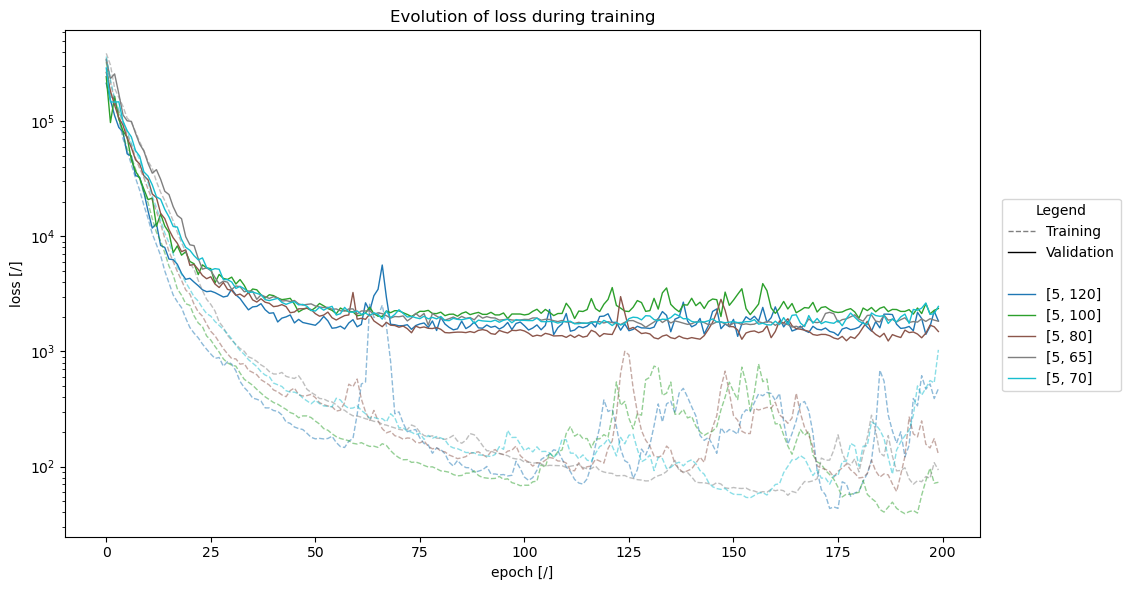

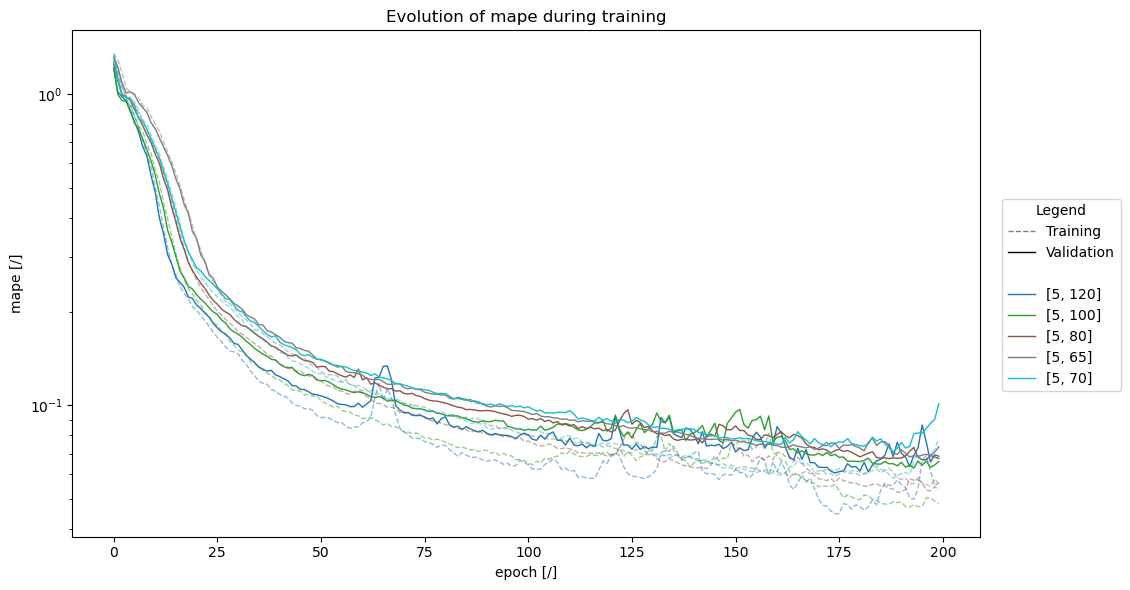

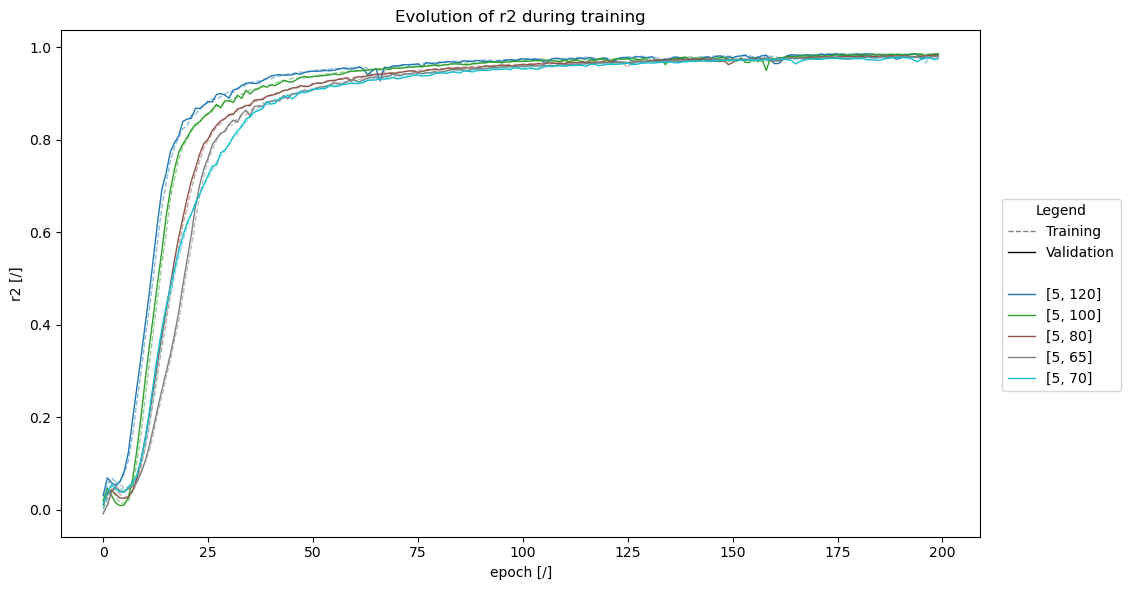

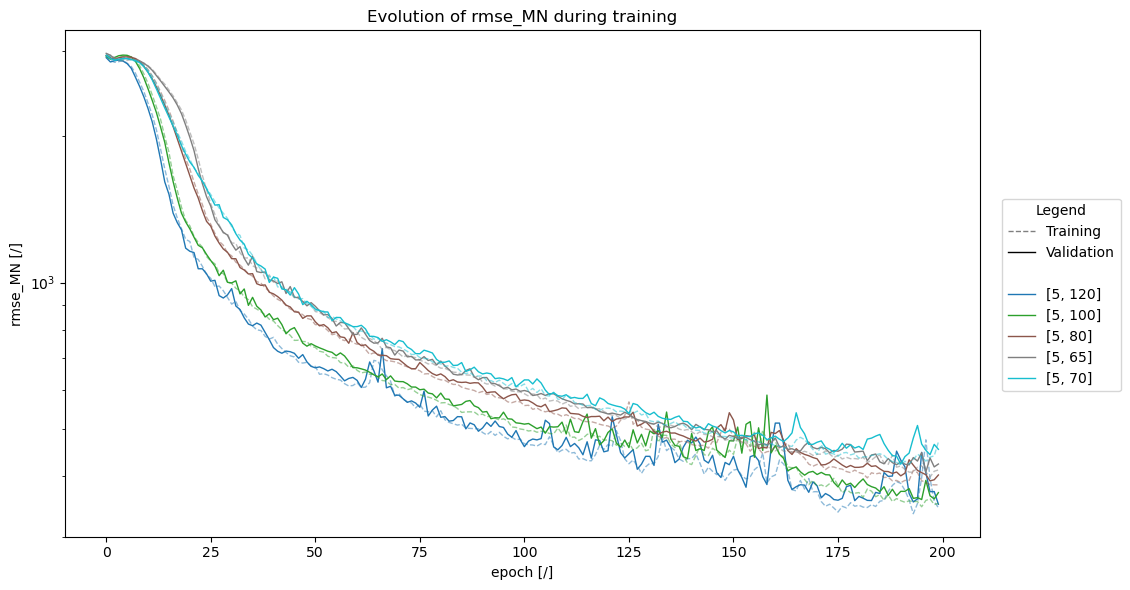

In [34]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs][:5]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [35]:
best_hidden_dims = [65 for _ in range(5)]

### Activation function

In [36]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run zealous-frog-489 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/3a288ed6b57f42ab9f78e4f1afbedcf0
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run chill-quail-798 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/8f3dec22e1e94447b89f8c9fbd714412
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run beautiful-hawk-23 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/2a42899e1b80434cae475bcbc40ecf6c
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run wise-mare-790 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/a7d64d2899764ebeb1f7f42c54158e7e
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/934184536802350089
🏃 View run debonair-toad-123 at: http://127.0.0.1:5005/#/experiments/934184536802350089/runs/9de344a9e26f4de5b1894dde930d7159
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/93418453680

In [37]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

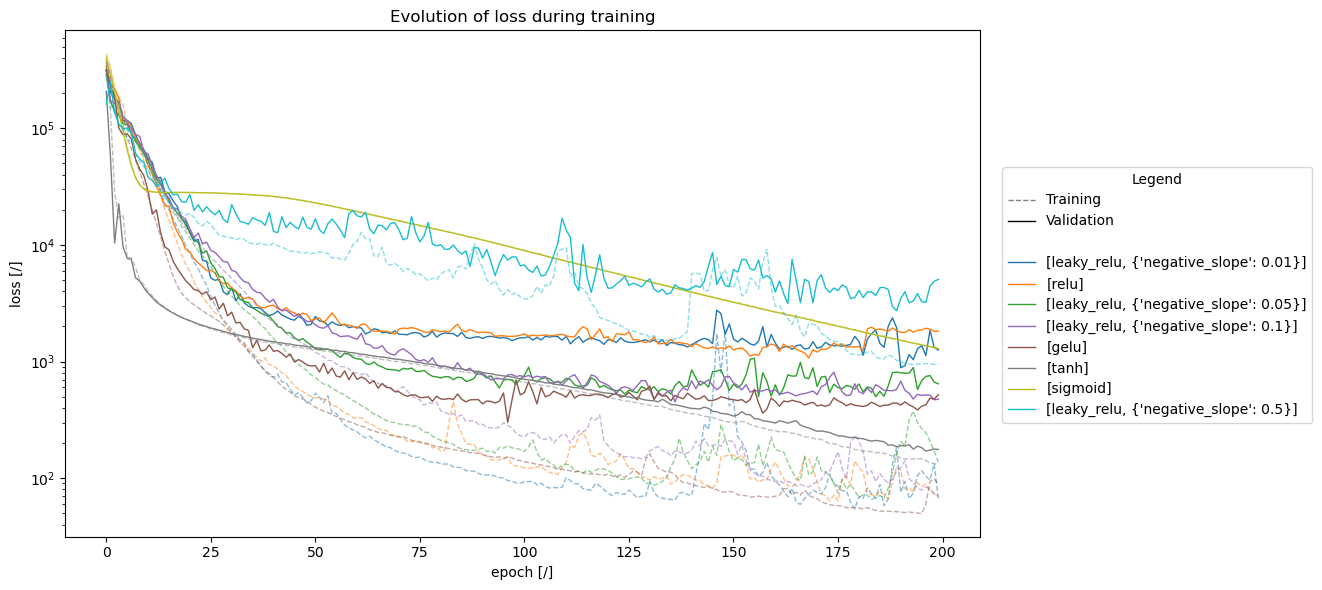

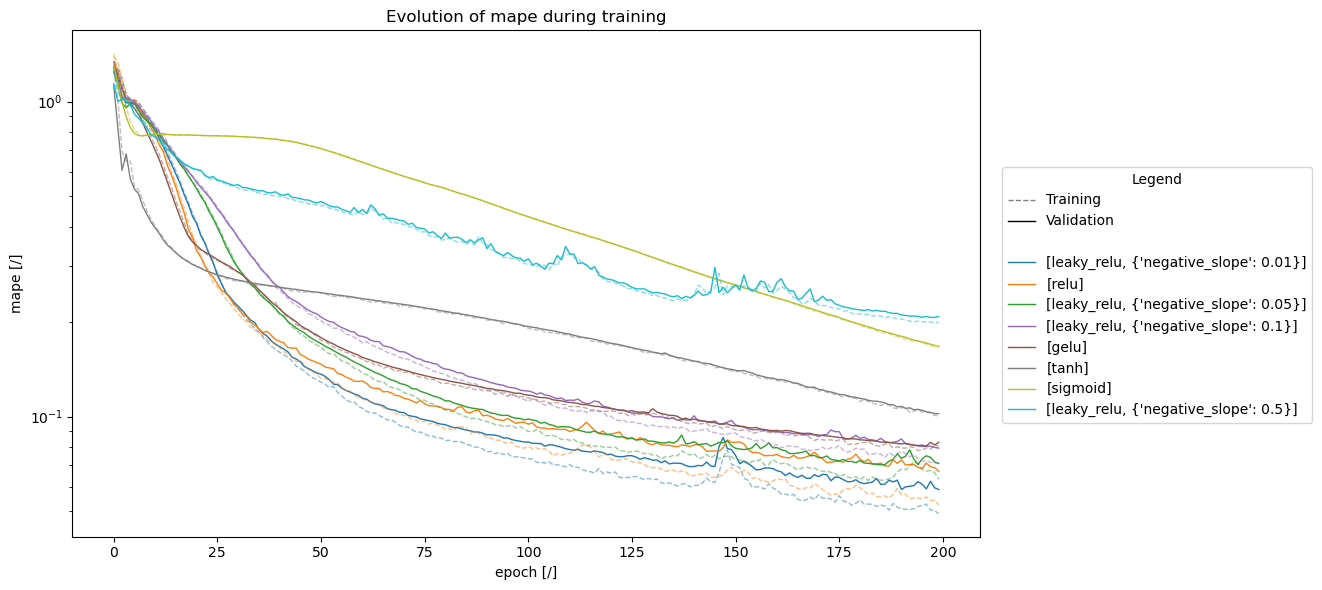

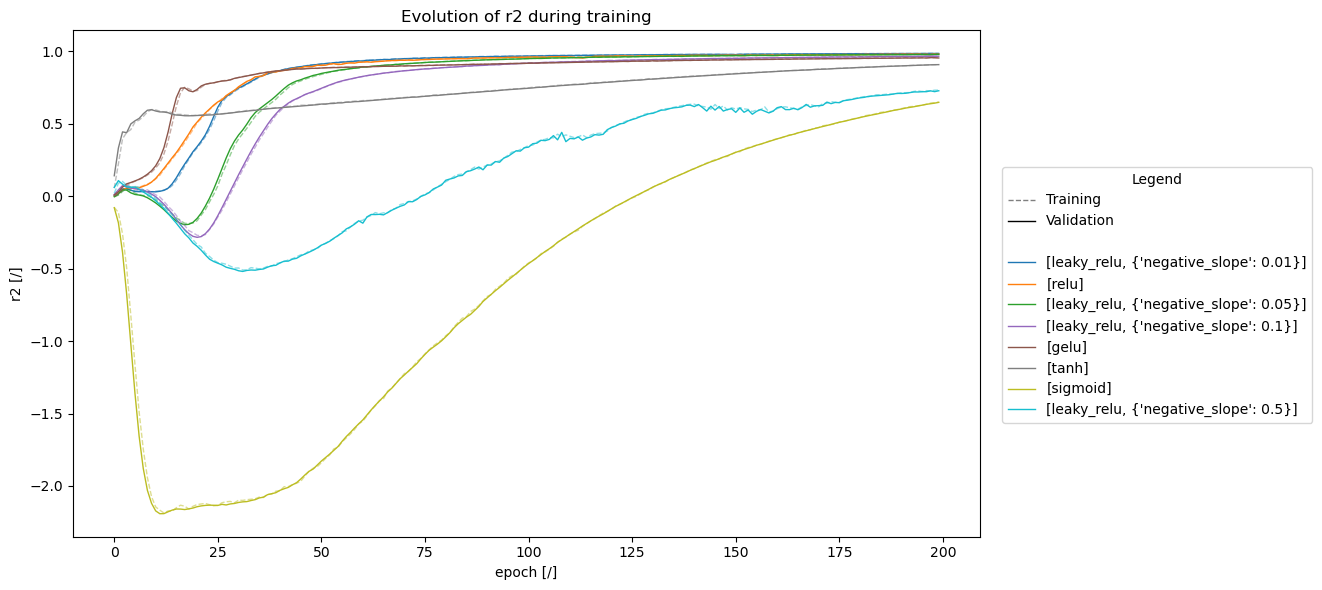

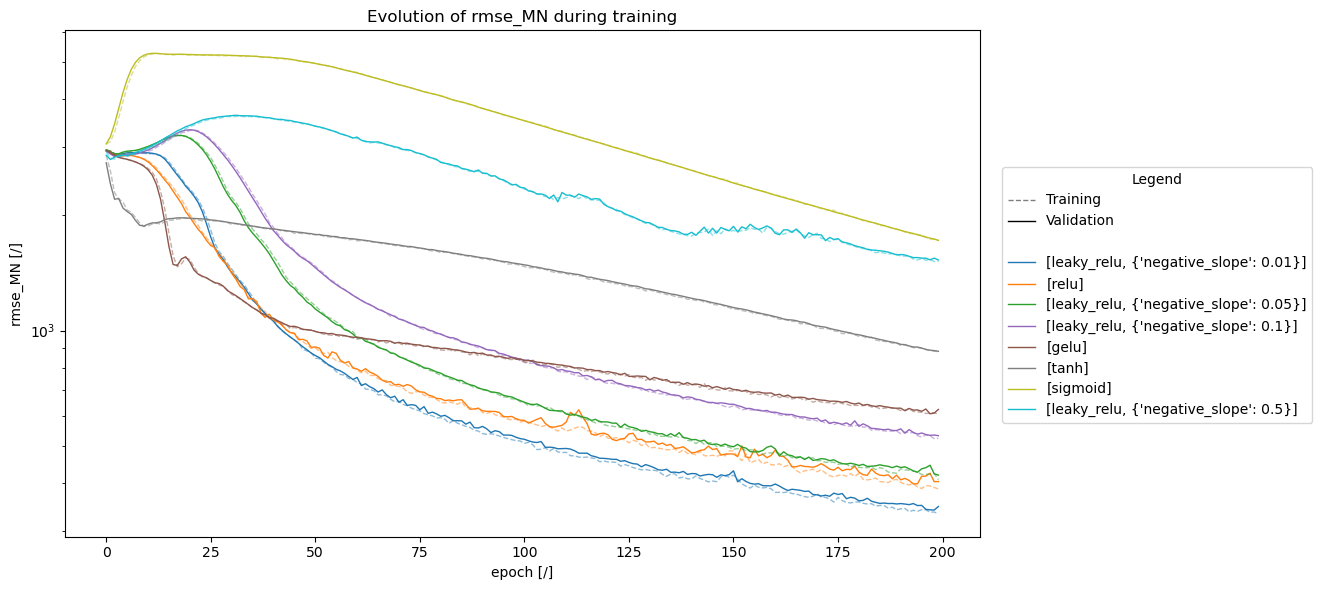

In [38]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [39]:
best_activation = 'leaky_relu'
best_activation_params = {'negative_slope': 1e-2}

### Learning rate

In [40]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in sorted(np.hstack([f * np.logspace(-5, -2, 4) for f in [1, 2.5, 5, 7.5]])):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, StiffnessToLoadLoss, kfold, log_step, {'loss': 'pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run luxuriant-hound-856 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/30f124fae8f241feb5a8d33e91404ee1
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run victorious-toad-951 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/f9b20b9810604362a65bebcfd5dd5789
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run suave-colt-123 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/fb33907da41a42ebbddb83d82b08b1f3
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run abrasive-shoat-293 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/62cd1374fbc840c28929eb8aa547024c
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/592595490478536282
🏃 View run intelligent-bug-21 at: http://127.0.0.1:5005/#/experiments/592595490478536282/runs/9f216bbde2c046e6adfd4a8c1d47b7f3
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/5

In [41]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

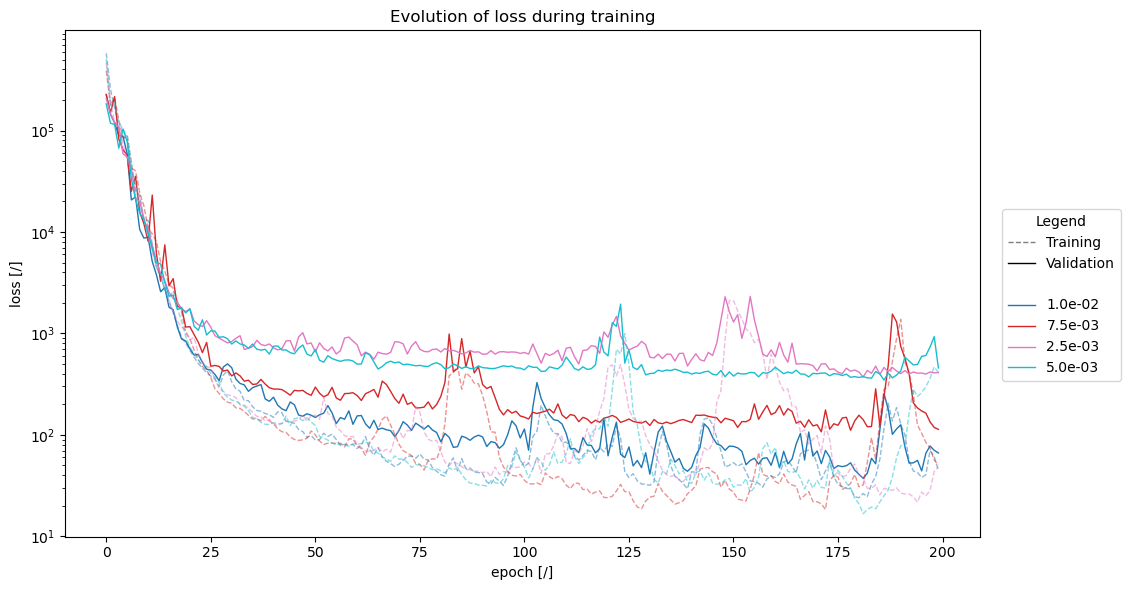

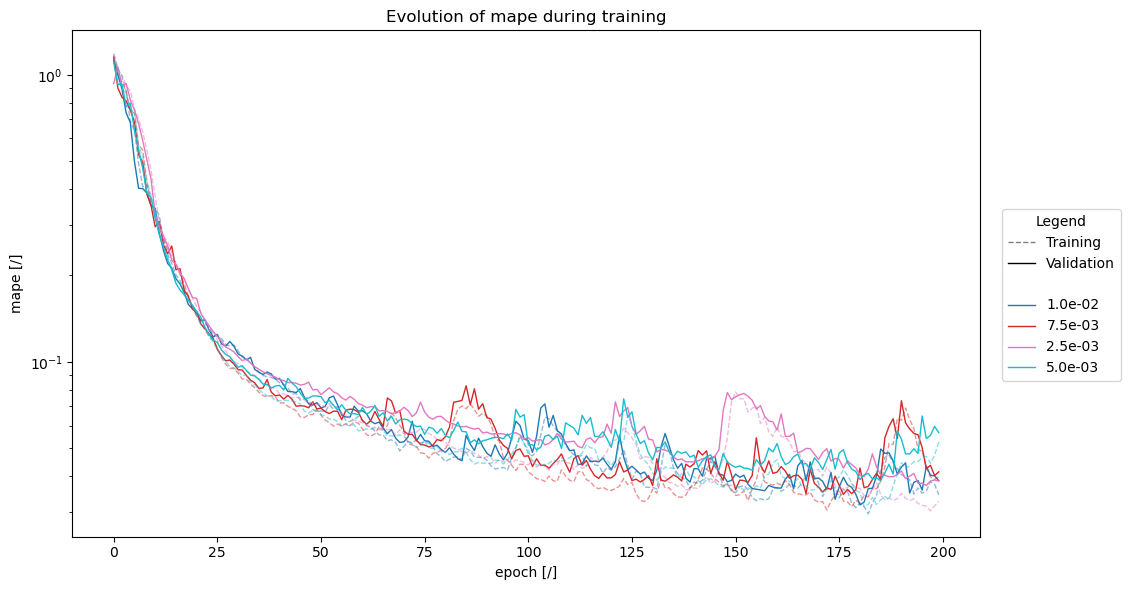

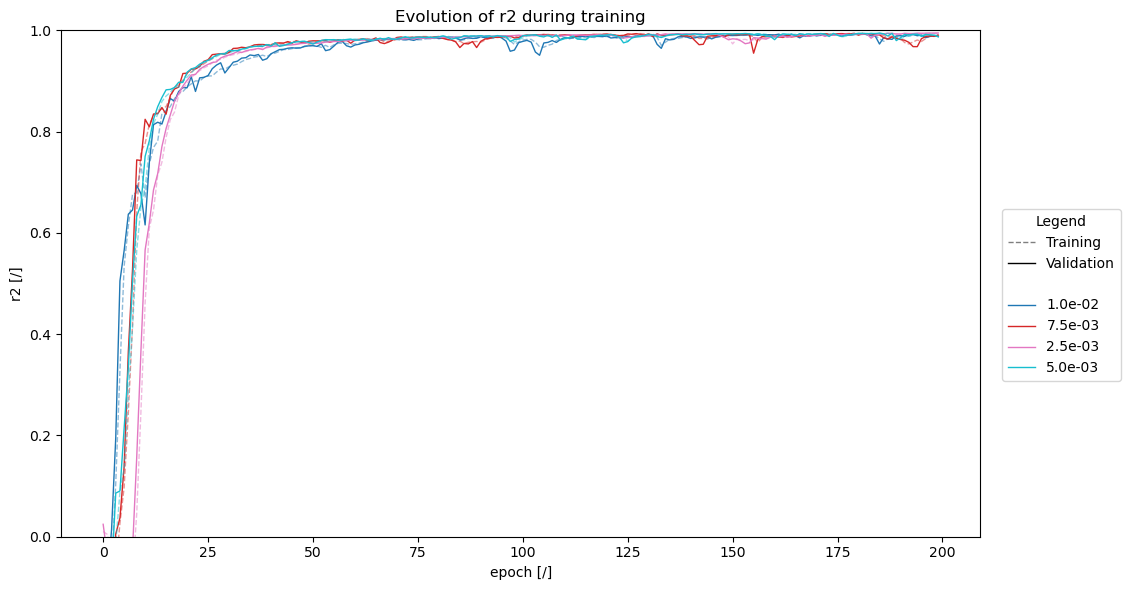

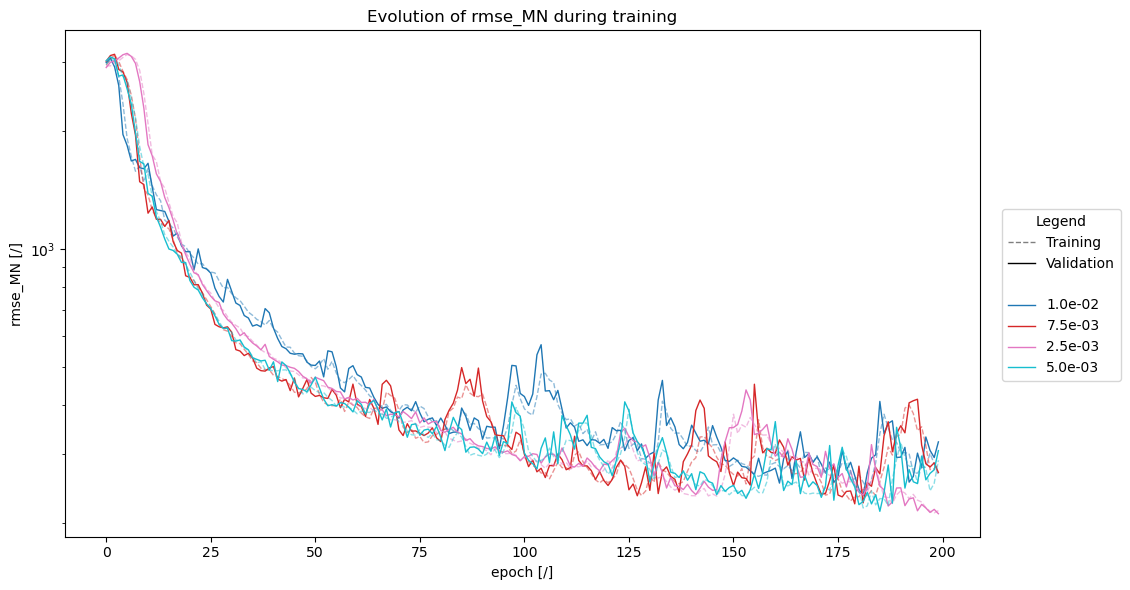

In [42]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs][:4]

"""configs = [
 '7.5e-04',
 '5.0e-04',
 '2.5e-04',
 '1.0e-04',]
"""
labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [43]:
best_lr = 5e-4

### Training

In [44]:
best_lr_old = best_lr
best_lr = 5e-4

mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDatasetSingleTarget(dataset_path)
        validation_dataset = _validation_ds
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 1,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, StiffnessToLoadLoss,
                                 -1, log_step, {'loss': 'pinn', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run invincible-goose-646 at: http://127.0.0.1:5005/#/experiments/425589307229459935/runs/e4b0f2dc9e2f4618ba44fb9f370073e3
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/425589307229459935
🏃 View run glamorous-crab-618 at: http://127.0.0.1:5005/#/experiments/425589307229459935/runs/ab50449d192b4e719edaab5ad658530b
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/425589307229459935
🏃 View run invincible-owl-901 at: http://127.0.0.1:5005/#/experiments/425589307229459935/runs/ea8d76b5cde9460297ef46f057ccd558
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/425589307229459935
🏃 View run thundering-lynx-266 at: http://127.0.0.1:5005/#/experiments/425589307229459935/runs/22c8a3ac3a4f4316884bd8938989d7c3
🧪 View experiment at: http://127.0.0.1:5005/#/experiments/425589307229459935
🏃 View run incongruous-foal-970 at: http://127.0.0.1:5005/#/experiments/425589307229459935/runs/c84a703b260a4508a1608e31ef206c85
🧪 View experiment at: http://127.0.0.1:5005/#/experi

In [45]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'pinn') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1000 and the array at index 1 has size 0

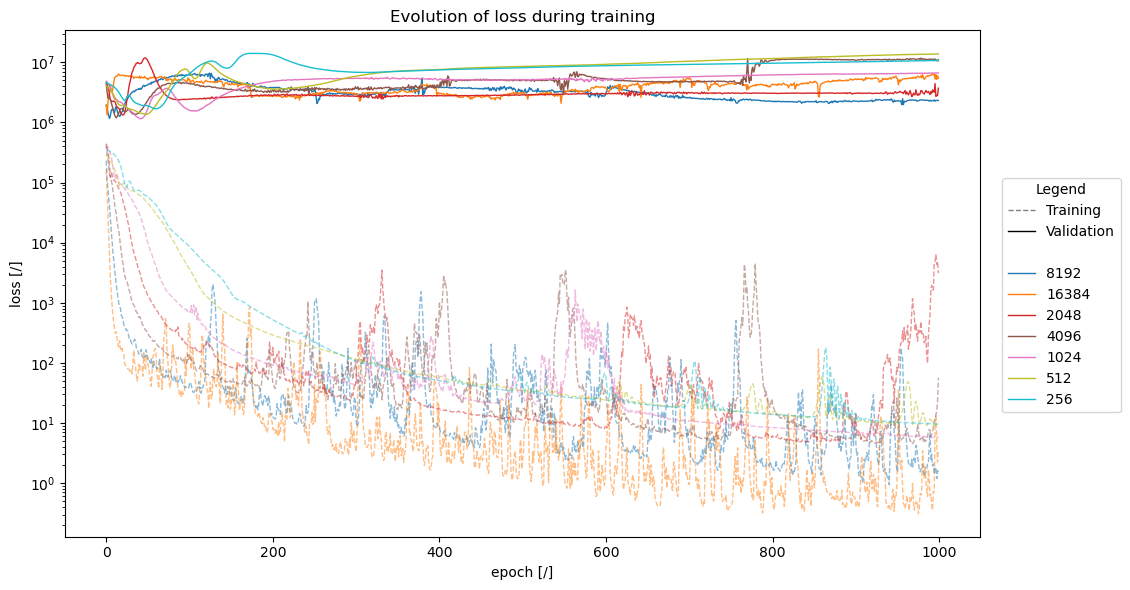

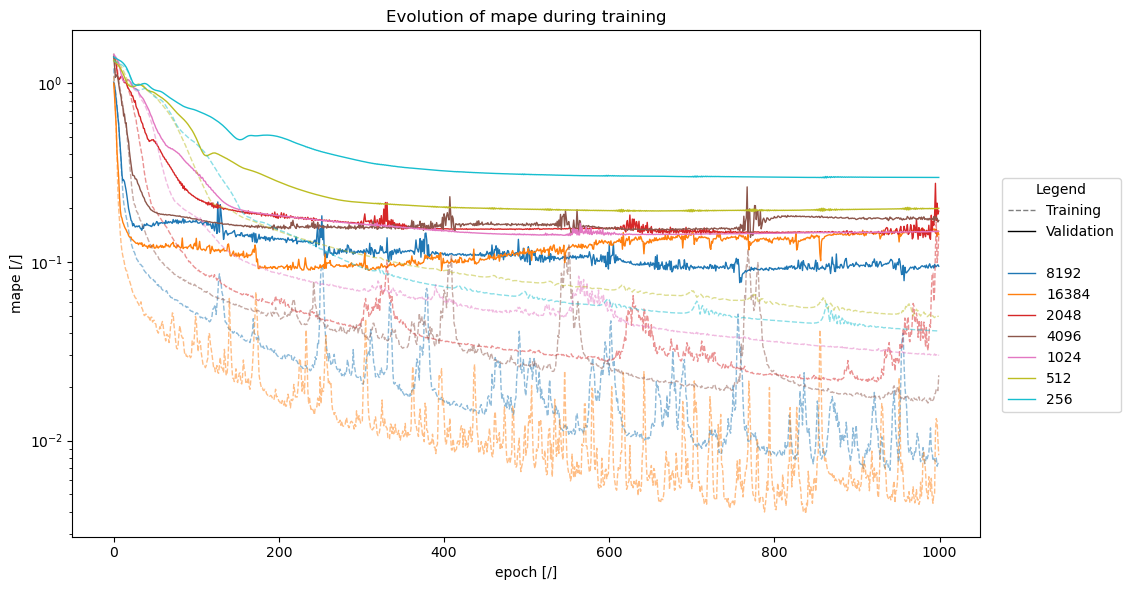

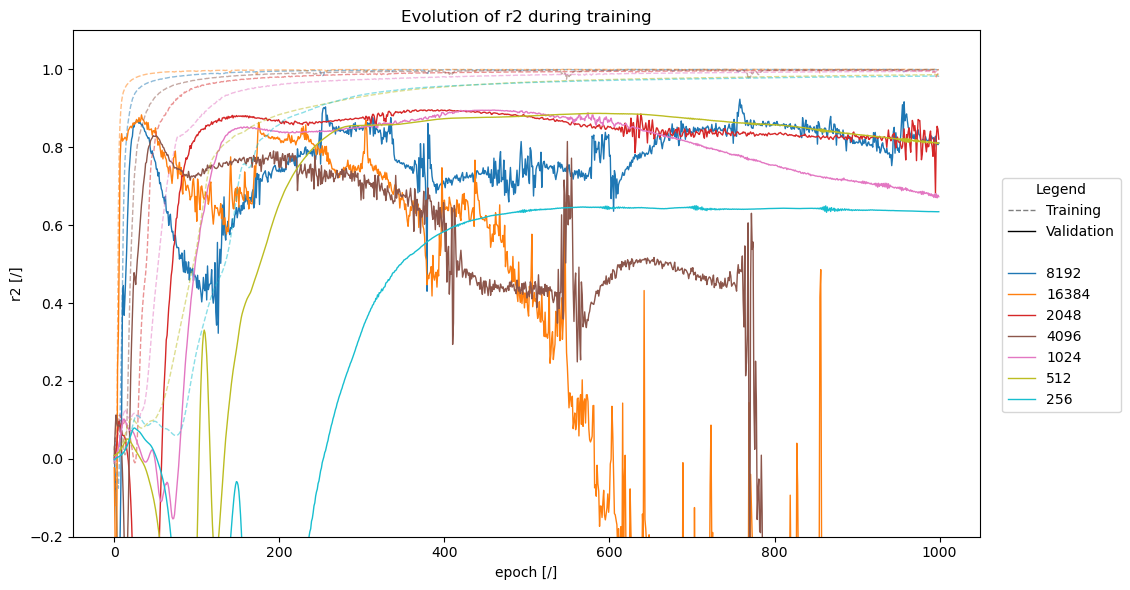

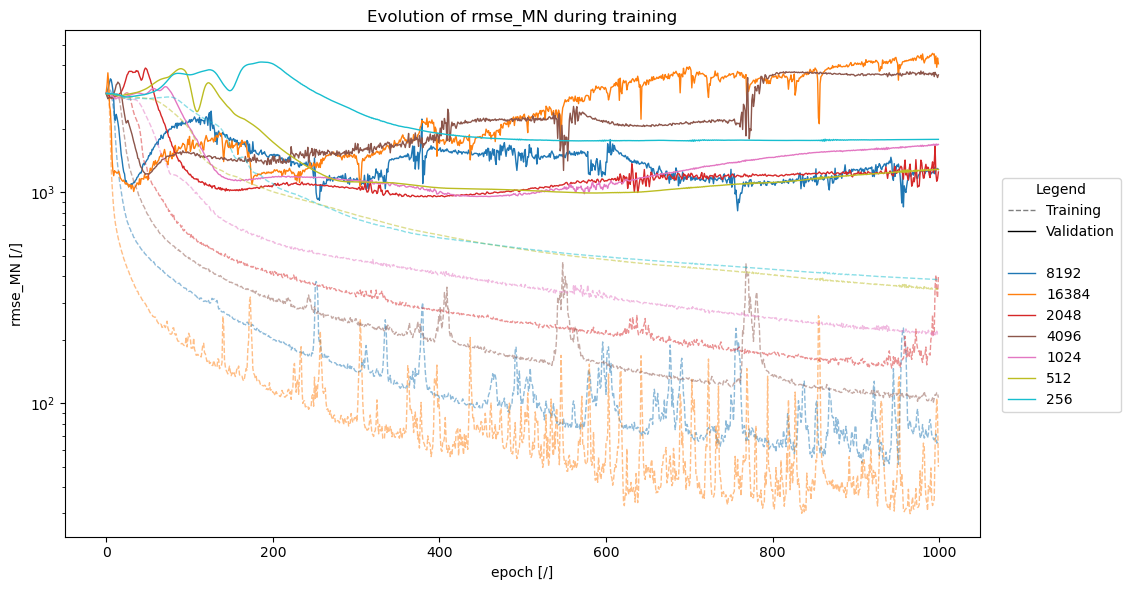

In [27]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [31]:
%%capture
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

results = []

for f in np.linspace(0, .1, 6):
    validation_ds = FixedPrattTrussDatasetSingleTarget(
        "data/dataset/pratt_truss_bridge/member_ea/validation_8192.hdf5",
        f_noise_length=None,
        f_noise_loads=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_strain=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_displacement=lambda size: np.random.normal(1, f / 4, size=size),
    )

    dl = DataLoader(validation_ds, batch_size=8192)

    for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
        artifact_uri = runs_df.iloc[i]['artifact_uri']
        size = runs_df.iloc[i]['params.train_size']

        uri = f"{artifact_uri}/input_scaler/"
        input_scaler = load_model(uri)

        uri = f"{artifact_uri}/target_scaler/"
        target_scaler = load_model(uri)

        uri = f"{artifact_uri}/mape_model/"
        model = load_model(uri)

        for batch in dl:
            metrics = validation(model, batch, input_scaler, target_scaler, StiffnessToLoadLoss())
        results.append((size, f, metrics))

In [32]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("noise_sensitivity")

df = pd.DataFrame([[results[i][0], results[i][1],
                    results[i][2]['r2'].item(),
                    results[i][2]['mape'].item(),
                    results[i][2]['rmse_MN'].item(),
                    results[i][2]['loss']]
                   for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

for size in df.train_size.unique():
    with mlflow.start_run():
        df_2 = df[df['train_size'] == size]
        # Model information logging
        mlflow.log_params({
            'train_size': size,
            'loss': 'mse'
        })
        for i in range(len(df_2)):
            mlflow.log_metrics(
                dict(df_2.iloc[i][1:]),
                step=i
            )

🏃 View run sincere-shrike-826 at: http://127.0.0.1:5001/#/experiments/791907198436629987/runs/dee0e896b7e44b65ba5aef4b15a8dd8d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/791907198436629987
🏃 View run illustrious-seal-323 at: http://127.0.0.1:5001/#/experiments/791907198436629987/runs/72841496f7b043c38f9d44330da61634
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/791907198436629987
🏃 View run valuable-fox-935 at: http://127.0.0.1:5001/#/experiments/791907198436629987/runs/04cbca63f86a4aa983ba6f973a384044
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/791907198436629987
🏃 View run welcoming-ram-32 at: http://127.0.0.1:5001/#/experiments/791907198436629987/runs/f84d391d22894faeaa5c6762480fb093
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/791907198436629987
🏃 View run rumbling-sponge-320 at: http://127.0.0.1:5001/#/experiments/791907198436629987/runs/c028cf0fae454f0689ede5033e002846
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/

# MSE + PINN

In [33]:
ds = FixedPrattTrussDatasetSingleTarget("data/dataset/pratt_truss_bridge/single_ea/train_128.hdf5")
k_s = (int(ds.stiffness_matrix[0].__len__() ** .5),) * 2
k_ref = ds.stiffness_matrix[0].reshape(k_s).astype(np.float64)
k_ref /= ds[0][1]
k_ref[[0, 1, 17], [0, 1, 17]] = 1
#k_ref[k_ref.abs() < 1e-9] = 0
k_ref = k_ref.to(torch.float32).to(device)

In [34]:
def u_from_x(x, n_panels=8):
    batch_size = len(x)
    u = torch.zeros((batch_size, 4 * n_panels), device=x.device)
    u[:, 2:2 * n_panels + 1] = x[:, :2 * (n_panels - 1) + 1]
    u[:, 2 * (n_panels + 1):] = x[:, 2 * (n_panels - 1) + 1:4 * n_panels - 3]
    return u.unsqueeze(-1)


def q_from_x_q(x, q, n_panels=8):
    q = q.squeeze(-1)
    q[:, np.arange(3, 2 * n_panels, 2)] = x[:, 4 * n_panels - 3: 5 * n_panels - 4]

    return q.unsqueeze(-1)


def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion_data, criterion_phys, f_criterion_phys):
    model.train()

    input, target, _, u, q = batch
    input, target = input.to(device), target.to(device)
    u, q = u.to(device), q.to(device)
    q[:, [0, 1, 17], :] = 0.

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = k_ref * target_pred.unsqueeze(-1)
    k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

    optimizer.zero_grad()
    loss_data = criterion_data(z_target_pred, z_target)
    loss_phys = criterion_phys(k_pred * 1e-6,
                               u_from_x(input, 8) * 1e3,
                               q_from_x_q(input, q, 8) * 1e-3)

    loss = loss_data + loss_phys * f_criterion_phys
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion_data, criterion_phys, f_criterion_phys):
    model.eval()
    with torch.no_grad():
        input, target, _, u, q = batch
        input, target = input.to(device), target.to(device)
        u, q = u.to(device), q.to(device)
        q[:, [0, 1, 17], :] = 0.

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = k_ref * target_pred.unsqueeze(-1)
        k_pred[:, [0, 1, 17], [0, 1, 17]] = 1.

        loss_data = criterion_data(z_target_pred, z_target)
        loss_phys = criterion_phys(k_pred * 1e-6,
                                   u_from_x(input, 8) * 1e3,
                                   q_from_x_q(input, q, 8) * 1e-3)
        loss = loss_data + loss_phys * f_criterion_phys

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss_data'] = loss_data.item()
    metrics['loss_phys'] = loss_phys.item()
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch + 1)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss', 'loss_data', "loss_phys"] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer,
          criterion_data, criterion_phys, f_criterion_phys, log_step=10):
    model = model.to(device)
    criterion_phys = criterion_phys.to(device)
    criterion_data = criterion_data.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_phys': {model: None, 'value': np.inf, 'epoch': -1},
        'loss_data': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer,
                                             criterion_data, criterion_phys, f_criterion_phys)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler,
                                           criterion_data, criterion_phys, f_criterion_phys)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion_data, criterion_phys, f_criterion_phys,
                  fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': lr,
            'criterion_data': criterion_data.__name__,
            'criterion_phys': criterion_phys.__name__,
            'pinn_factor': f_criterion_phys
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr),
                      criterion_data(), criterion_phys(), f_criterion_phys,
                      log_step=log_step)

In [35]:
def plot(results, configs, metric, labels, log=True, xlim=None, ylim=None):
    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data but collect the handles for the legend
    config_handles = []
    for i, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])
        h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
        h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
        config_handles.append(h2)

    # Create custom handles for the line style legend
    line_style_handles = [
        Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
        Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
        Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
    ]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    all_handles = line_style_handles + config_handles
    all_labels = ['Training', 'Validation', ''] + labels

    # Create a single legend with both line styles and configurations
    plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                  title="Legend")

    ax.set_title(f"Evolution of {metric} during training")
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{metric} [/]")
    ax.set_xlabel("epoch [/]")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)

    plt.tight_layout()
    # Adjust right padding to make room for the legend
    plt.show()

## Hyperparameter tuning

## Loss factor

In [45]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("pinn_loss_factor")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

factor_values = np.logspace(-6, -5, 2)#np.logspace(-4, 1, 6)
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for f_pinn in factor_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': [60 for _ in range(4)],
                                         'output_dim': 1,
                                         'activation': "relu",
                                         'activation_params': None,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run delicate-fawn-408 at: http://127.0.0.1:5001/#/experiments/939484249728390556/runs/2f53d431657146649b82ddb8a41d578d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/939484249728390556
🏃 View run grandiose-crow-53 at: http://127.0.0.1:5001/#/experiments/939484249728390556/runs/bdd309e18d9344d1833e1b19147a260a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/939484249728390556
🏃 View run spiffy-toad-491 at: http://127.0.0.1:5001/#/experiments/939484249728390556/runs/303f17a2363d427fa1582db03fd3fea9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/939484249728390556
🏃 View run skittish-bass-489 at: http://127.0.0.1:5001/#/experiments/939484249728390556/runs/8d377f608ebe40a0b1d8aeddd7ab8ce6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/939484249728390556
🏃 View run puzzled-jay-279 at: http://127.0.0.1:5001/#/experiments/939484249728390556/runs/1401ad574db44d18b30e51774408513b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/93948424

In [46]:
best_f_pinn = .1

In [47]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("pinn_loss_factor")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

pinn_factors = set(runs_df['params.pinn_factor'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in pinn_factors}
for f in pinn_factors:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.pinn_factor'] == f)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[f][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

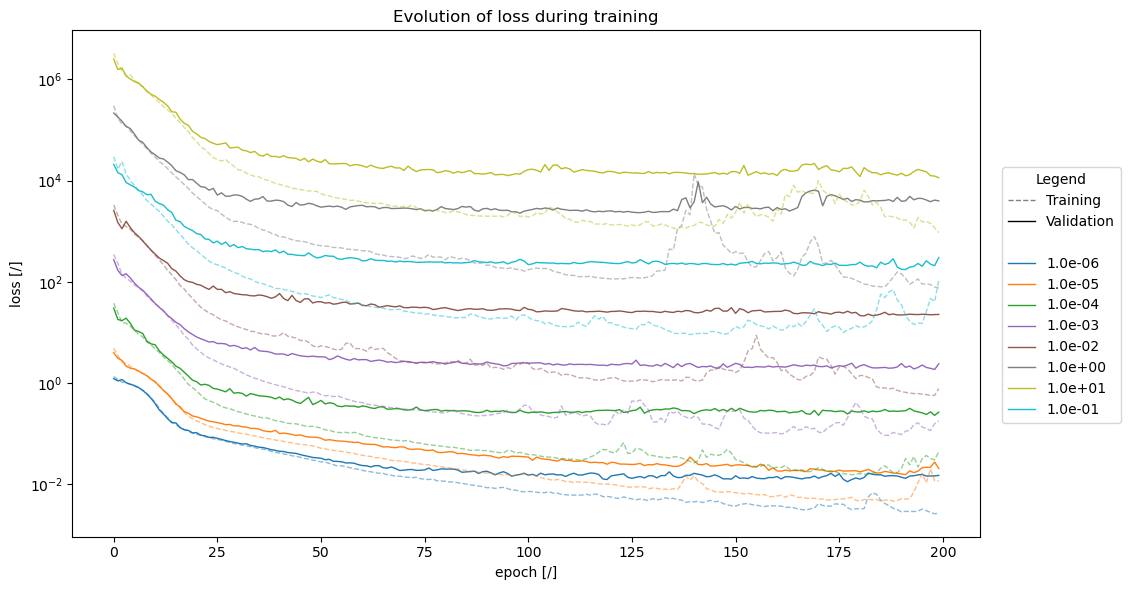

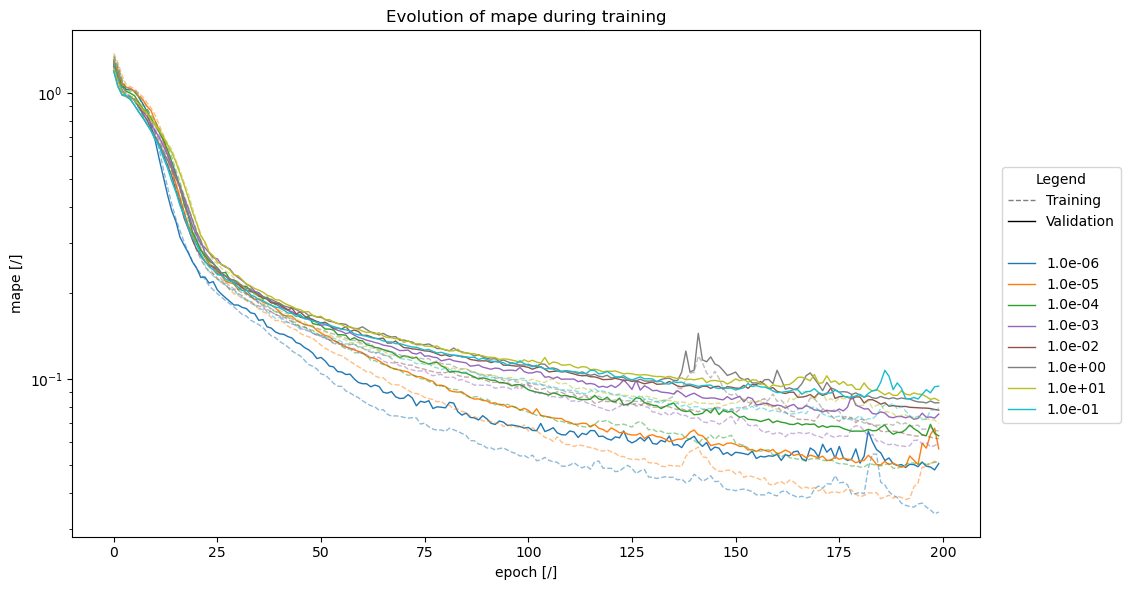

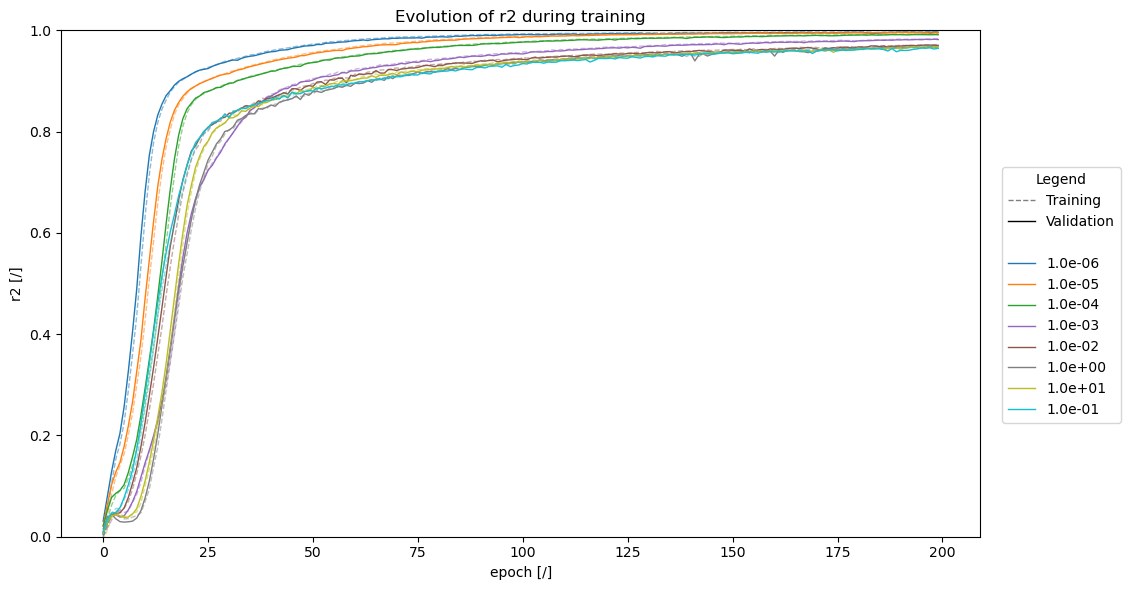

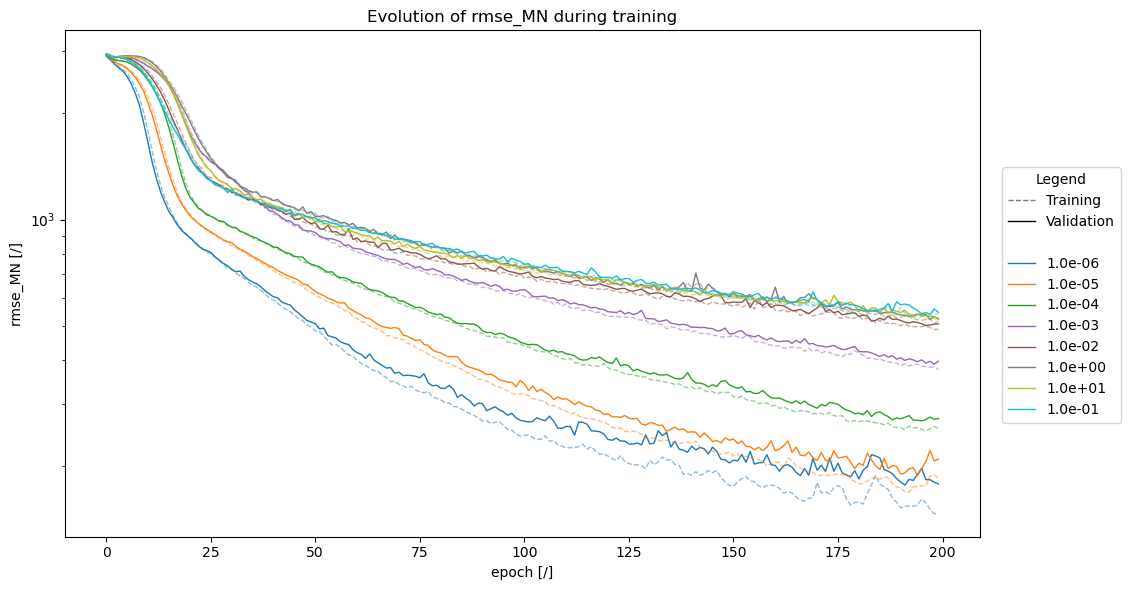

In [49]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

### Model capacity

In [22]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("model_capacity")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': 65,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': 1,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                         kfold, log_step, {'loss': 'mse + pinn'})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

🏃 View run capricious-snail-911 at: http://127.0.0.1:5000/#/experiments/994705927686486388/runs/31d308fab5f244e3ab11f8fe2b6e2dc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/994705927686486388
🏃 View run stately-slug-225 at: http://127.0.0.1:5000/#/experiments/994705927686486388/runs/09e876058994443d963e2494af25ab0d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/994705927686486388
🏃 View run bouncy-carp-154 at: http://127.0.0.1:5000/#/experiments/994705927686486388/runs/5de02f4c303e4a01bb176d379d9c7391
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/994705927686486388
🏃 View run sincere-perch-103 at: http://127.0.0.1:5000/#/experiments/994705927686486388/runs/f2e833de4adf41a8a21503a8a73755ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/994705927686486388
🏃 View run brawny-cat-864 at: http://127.0.0.1:5000/#/experiments/994705927686486388/runs/aadb85a0dfc34472b8d7888d77654246
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9947059

In [34]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("model_capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

keys = list(results.keys())
for k in keys:
    vi = results[k].values().__iter__().__next__()
    if len(vi) == 0: del results[k]

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

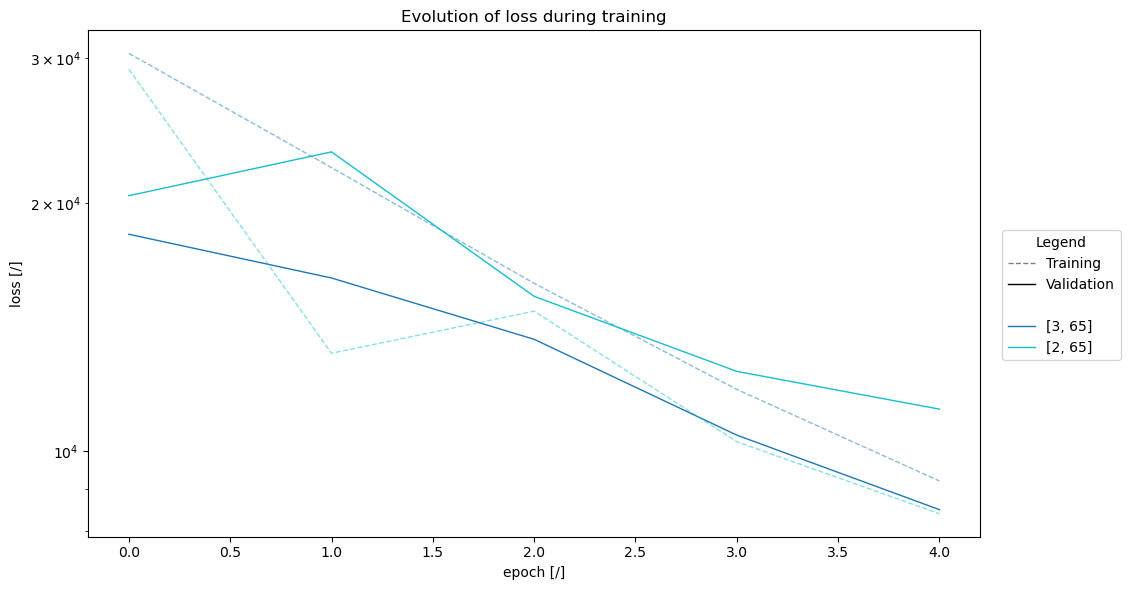

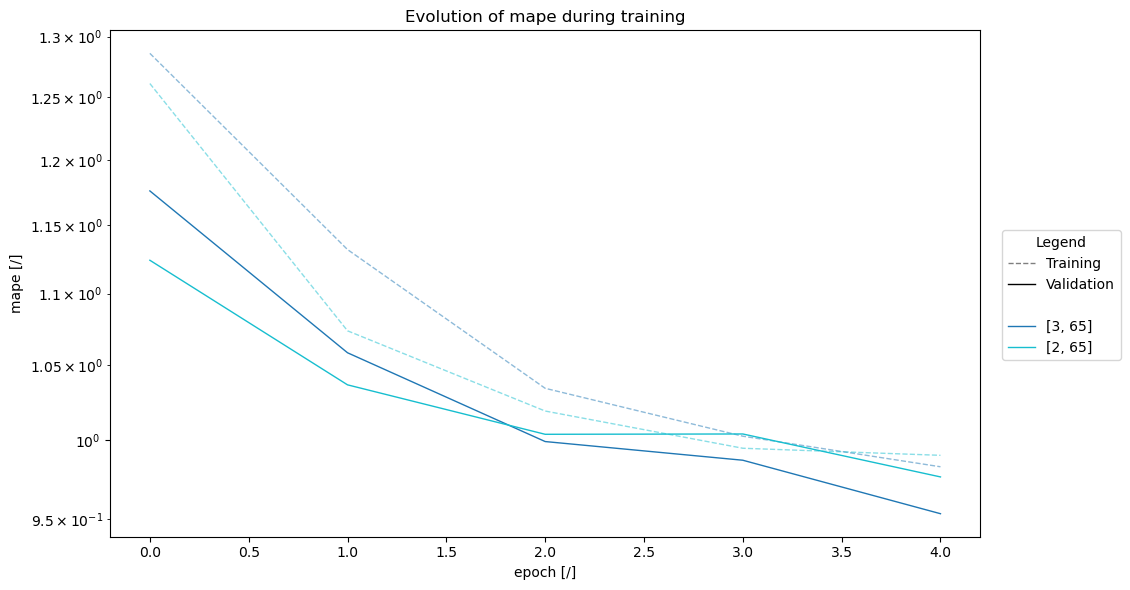

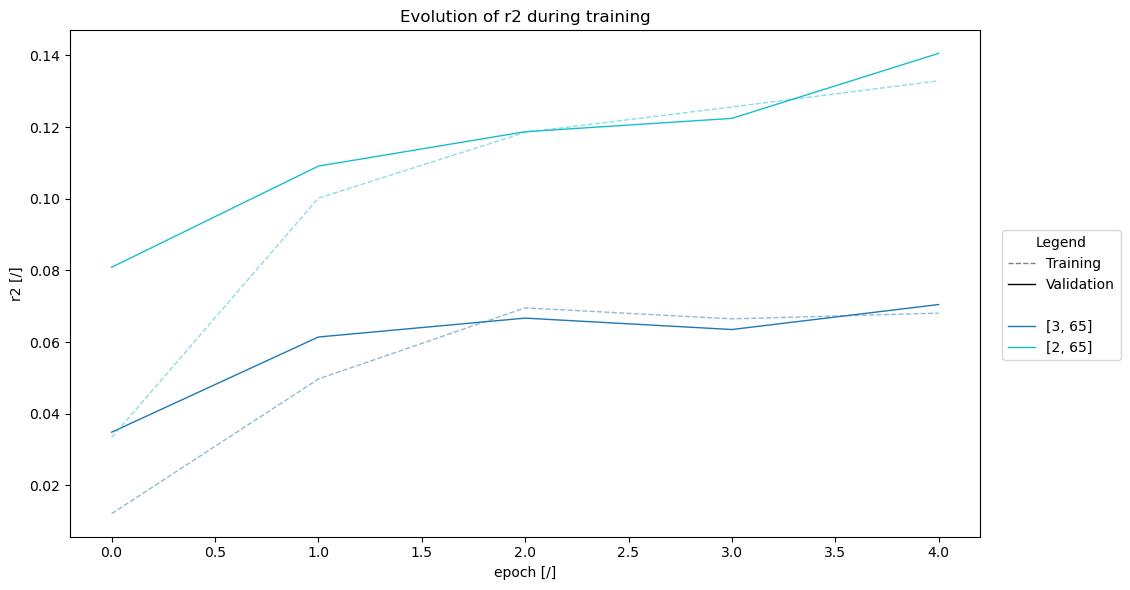

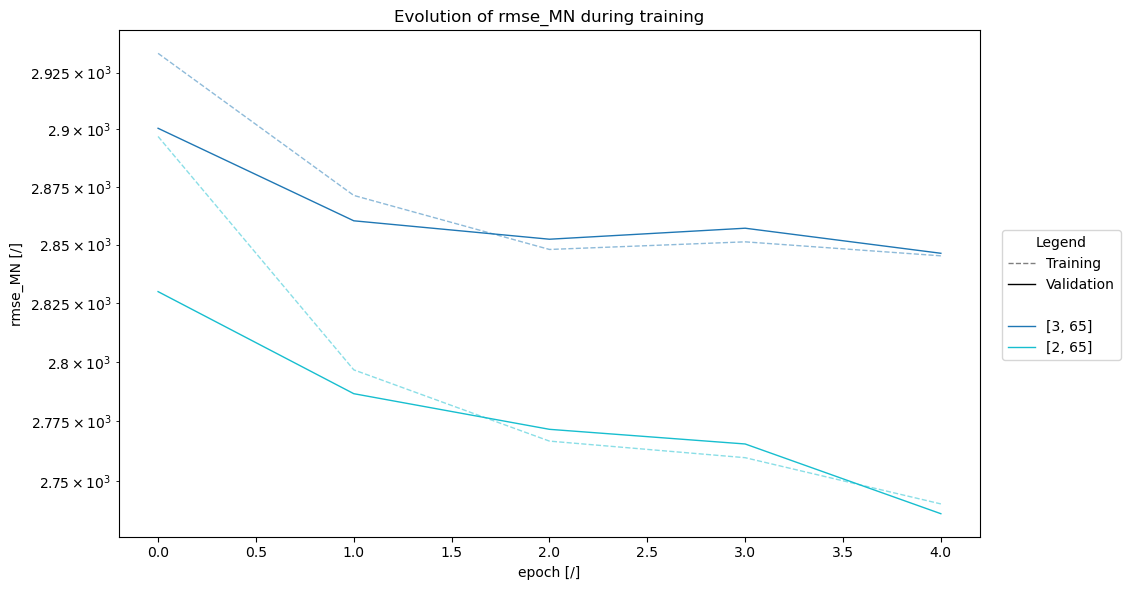

In [35]:
# Your existing code for preparing the data
_configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = _configs
configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [ ]:
best_hidden_dims = [60 for _ in range(5)]

### Activation function

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("activation_function")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

In [ ]:
# Your existing code for preparing the data
configs = [x[1] for x in sorted([(np.min(v['val_mape']), k) for k, v in results.items()])]
labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False)
plot(results, configs, 'rmse_MN', labels)

In [ ]:
best_activation = 'leaky_relu'
best_activation_params = {'negative_slope': 1e-2}

### Learning rate

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("learning_rate")

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

N_EPOCH = 200
LR = 5e-4

log_step = -1

kfold = 5
dataset_path = "data/dataset/pratt_truss_bridge/single_ea/train_4096.hdf5"
ds = FixedPrattTrussDatasetSingleTarget(dataset_path)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in sorted(np.hstack([f * np.logspace(-5, -2, 4) for f in [1, 2.5, 5, 7.5]])):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': 65,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': 1,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                     kfold, log_step, {'loss': 'mse + pinn'})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

In [ ]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs][:4]

"""configs = [
 '7.5e-04',
 '5.0e-04',
 '2.5e-04',
 '1.0e-04',]
"""
labels = [f"{float(c):.1e}" for c in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(0, 1))
plot(results, configs, 'rmse_MN', labels)

In [ ]:
best_lr = 5e-4

### Training

In [ ]:
best_lr_old = best_lr
best_lr = 5e-4

mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]  # [int(min(np.power(2, np.floor(np.log2(n)) - 1), 512)) for n in sizes]
dataset_path_values = [f"data/dataset/pratt_truss_bridge/single_ea/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDatasetSingleTarget(dataset_path)
        validation_dataset = _validation_ds
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': 65,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': 1,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_lr, nn.MSELoss, StiffnessToLoadLoss, best_f_pinn,
                                 -1, log_step, {'loss': 'pinn', 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse + pinn') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

In [ ]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, 'loss', labels)
plot(results, configs, 'mape', labels)
plot(results, configs, 'r2', labels, log=False, ylim=(-.2, 1.1))
plot(results, configs, 'rmse_MN', labels)

### Noise sensitivity

In [ ]:
%%capture
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

results = []

for f in np.linspace(0, .1, 6):
    validation_ds = FixedPrattTrussDatasetSingleTarget(
        "data/dataset/pratt_truss_bridge/member_ea/validation_8192.hdf5",
        f_noise_length=None,
        f_noise_loads=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_strain=lambda size: np.random.normal(1, f / 4, size=size),
        f_noise_displacement=lambda size: np.random.normal(1, f / 4, size=size),
    )

    dl = DataLoader(validation_ds, batch_size=8192)

    for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
        artifact_uri = runs_df.iloc[i]['artifact_uri']
        size = runs_df.iloc[i]['params.train_size']

        uri = f"{artifact_uri}/input_scaler/"
        input_scaler = load_model(uri)

        uri = f"{artifact_uri}/target_scaler/"
        target_scaler = load_model(uri)

        uri = f"{artifact_uri}/mape_model/"
        model = load_model(uri)

        for batch in dl:
            metrics = validation(model, batch, input_scaler, target_scaler, F.mse_loss)
        results.append((size, f, metrics))

In [ ]:
mlflow.set_tracking_uri(uri=MLFLOW_URI(port=PORT))
mlflow.set_experiment("noise_sensitivity")

df = pd.DataFrame([[results[i][0], results[i][1],
                    results[i][2]['r2'].item(),
                    results[i][2]['mape'].item(),
                    results[i][2]['rmse_MN'].item(),
                    results[i][2]['loss']]
                   for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

for size in df.train_size.unique():
    with mlflow.start_run():
        df_2 = df[df['train_size'] == size]
        # Model information logging
        mlflow.log_params({
            'train_size': size,
            'loss': 'mse'
        })
        for i in range(len(df_2)):
            mlflow.log_metrics(
                dict(df_2.iloc[i][1:]),
                step=i
            )